# Epymorph dev log: May 31, 2023

Author: Alexander Nez

as of git hash:

### Social Determinate of Health (sdh)

### sdh toml params

infection_duration = 4.0

immunity_duration = 90.0

infection_seed_loc = 2451

infection_seed_size = 9708

hospitalization_duration = 5.3

alpha = [0.35, 0.04125, 0.05875]

gamma = 0.1000022

phi = 40



# SDH IPM

Plots sdh model by prevalence
python -m epymorph run --ipm basis_sdh --mm centroids --geo maricopa_cbg_2019 --params "./scratch/params/basis_sdh.toml" --start_date "2015-01-01" --duration "150d" --chart "p0" --out ./scratch/output_files/sdh.csv \\


Creates sirh_sdh
python -m epymorph run --ipm sdh --mm centroids --geo maricopa_cbg_2019 --params ./scratch/params/sdh_params.toml --start_date 2015-01-01 --duration 150d --out ./scratch/output_files/sdh.csv  
python -m epymorph run --input ./my-experiment.toml --chart e0

In [1]:
from epymorph.run import run
from epymorph.data.ipm.initializer import BottomLocsInitializer, IndexedLocsInitializer, LabeledLocsInitializer, RandomLocsInitializer, TopLocsInitializer
from epymorph.data import geo_library, ipm_library, mm_library
from epymorph.data.ipm.sdh import sirhBuilder as SdhBuilder
from epymorph.simulation import Simulation
from epymorph.world import Population 
from epymorph.run import save_csv

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import interp1d, CubicSpline
from scipy.spatial.distance import squareform
from numpy.typing import DTypeLike, NDArray
from shapely.geometry import Point, Polygon
from scipy.spatial.distance import pdist
from matplotlib.gridspec import GridSpec
from IPython.core.display import SVG
from matplotlib.pyplot import xlabel
from matplotlib.patches import Circle
from shapely.geometry import Point
from scipy.optimize import minimize
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.stats import norm
from datetime import date
import geopandas as gpd
from numpy import size
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import random
import pydot
import time
import os



with np.load(f"./epymorph/data/geo/maricopa_cbg_2019_geo.npz") as npz_data:
        data = dict(npz_data)


API_KEY = os.getenv('CENSUS_API_KEY')
BASE_URL = 'https://geocoding.geo.census.gov/geocoder/locations/onelineaddress'

dir = os.path.expanduser('~/Desktop/Github/Epymorph/scratch')

In [ ]:
diagram_dot = """digraph {
    rankdir=LR;
    node [shape=box];
    S -> I [label="tau * (S * I * beta)"];
    I -> R [label="tau * (1 / D * (1 - gamma)) "];
    I -> H [label="tau * (1/D * gamma)"];
    H -> R [label="tau * (1 / Hosp)"];
    R -> S [label="tau * (1 / L)"]
}"""
diagram = pydot.graph_from_dot_data(diagram_dot)[0]  # type: ignore
SVG(data = diagram.create_svg())

# Functions


Fine tune to match maricopa flu data.

In [2]:
def calculate_beta(x):
    r0_min = 1.3
    r0_max = 2.0
    a = -180.0
    b = np.log(r0_max - r0_min)
    return (np.exp(a * x + b) + r0_min) / 4

def haversine(centroid_1_lon: float, centroid_1_lat: float,
              centroid_2_lon: float, centroid_2_lat: float) -> np.double:
    R = 3959.87433
    dLat = np.radians(centroid_1_lat - centroid_2_lat)
    dLon = np.radians(centroid_1_lon - centroid_2_lon)
    lat1 = np.radians(centroid_1_lat)
    lat2 = np.radians(centroid_2_lat)

    a = np.sin(dLat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dLon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    return R * c

def f(x, y, a, b, c, alpha_n, beta_n, gamma_m, phi_m):
    summation_term_1 = np.sum(alpha_n * beta_n(x))
    summation_term_2 = np.sum(gamma_m * phi_m(y))
    
    result = a * (np.exp(b * summation_term_1) + np.exp(c * summation_term_2))
    return result

def basis(x, y, a, b, c, alpha_n, beta_n, gamma_m, phi_m):
    summation_term_1 = np.sum(alpha_n * beta_n(x))
    summation_term_2 = np.sum(gamma_m * phi_m(y))
    
    result = a * (np.exp(b * summation_term_1) + np.exp(c * summation_term_2))
    return result

def cox_de_boor(u, i, k, t):
    """ Evaluates the Cox-de Boor recursion formula. """
    if k == 0:
        return 1.0 if t[i] <= u < t[i+1] else 0.0
    else:
        term1 = 0.0
        term2 = 0.0
        
        if (t[i + k] - t[i]) != 0:
            term1 = ((u - t[i]) / (t[i + k] - t[i])) * cox_de_boor(u, i, k-1, t)
            
        if (t[i + k + 1] - t[i+1]) != 0:
            term2 = ((t[i + k + 1] - u) / (t[i + k + 1] - t[i + 1])) * cox_de_boor(u, i+1, k-1, t)
        
        return term1 + term2
    
def geocode_address(address: str) -> tuple[float, float]:

    response = requests.get(BASE_URL, params={
        'address': address,
        'benchmark': 'Public_AR_Current',
        'format': 'json',
        'api_key': API_KEY,
    })

    if response.status_code != 200:
        raise Exception(
            f'Geocoding request failed: ({response.status_code}) {response.text}')

    matches = response.json()['result']['addressMatches']
    if len(matches) == 0:
        raise Exception('No match for that address.')
    elif len(matches) > 1:
        raise Exception('More than one match found for that address.')
    else:
        coords = matches[0]['coordinates']
        return (coords['x'], coords['y'])

# MCMC


# Simulation 

In [3]:
# Infect 10,000 people in 10 randomly chosen locations.
RandomLocsInitializer(
    infection_seed_size= 200,
    infection_locations=10
)

# Infect 10,000 people in these 4 location by index.
IndexedLocsInitializer(
    infection_seed_size=10_000,
    infection_locations=[46, 104, 154, 2445]
)

# Infect 10,000 people in these 4 locations by label.
LabeledLocsInitializer(
    infection_seed_size=235,
    infection_locations=['040131058001', '040130101012', '040130101013	', '040130101021', '040130101022']
)

# Infect 10,000 people in the 10 locations with the least median age
BottomLocsInitializer(
    infection_seed_size=10_000,
    infection_locations=10,
    infection_attribute='median_age'
)

# Infect 10,000 people in the 10 locations with the highest population
TopLocsInitializer(
    infection_seed_size=1_000,
    infection_locations=10,
    infection_attribute='pop_density_km2'
)

In [4]:
sdh_builder = SdhBuilder()
sdh_builder.initializer = RandomLocsInitializer(
    infection_seed_size= 200,
    infection_locations=10
)
sim = Simulation(
    geo=geo_library['maricopa_cbg_2019'](),
    ipm_builder=sdh_builder,
    mvm_builder=mm_library['centroids']()
)
 
out = sim.run( 
    param={
        'alpha': [0.35, 0.04125, 0.05875],
        'theta': 0.1,
        'gamma': 0.01000022,
        'phi': 40,
        'move_control': 0.9,
        'infection_duration': 6, # We may want to change this duration 
        'immunity_duration': 90.0,
        'hospitalization_duration': 5.3,
        },
        start_date=date(2019, 1, 1),
        duration_days=154,
        rng=np.random.default_rng(21)
        )
# This is not very interesting output, but you get the idea.
save_csv(f"{dir}/output_files/overleaf_sirh.csv", out)
    
out.prevalence[0, 0:10]

KeyboardInterrupt: 

In [ ]:
seed_size = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250]

sdh_builder = SdhBuilder()
sdh_builder.initializer = LabeledLocsInitializer(
    infection_seed_size= 225,
    infection_locations=['040131058001', '040130101012', '040130101013	', '040130101021', '040130101022']
)

sim = Simulation(
    geo=geo_library['maricopa_cbg_2019'](),
    ipm_builder=sdh_builder,
    mvm_builder=mm_library['centroids']()
)
 
phi = [10,20,30,40,50 ,60 ,70 ,80 ,90]

for i in range(len(phi)):
    out = sim.run( 
            param={
                'alpha': [0.35, 0.04125, 0.05875],
                'theta': 0.1,
                'gamma': 0.01000022,
                'phi': phi[i],
                'move_control': 0.9,
                'infection_duration': 6, # We may want to change this duration 
                'immunity_duration': 90.0,
                'hospitalization_duration': 5.3,
            },
            start_date=date(2019, 1, 1),
            duration_days=154,
            rng=np.random.default_rng(21)
        )
    phi_str = str(phi[i])
        # This is not very interesting output, but you get the idea.
    save_csv(f"{dir}/output_files/" + phi_str + "_sirh.csv", out)
    out.prevalence[0, 0:10]

In [14]:
exit_code = run(
    ipm_name = 'basis_sdh',
    mm_name = 'centroids',
    geo_name = 'maricopa_cbg_2019',
    start_date_str = '2015-01-01',
    duration_str = '150d',
    params_path = f"{dir}/params/basis_sdh.toml",
    out_path = f"{dir}/output_files/sirh.csv",
    chart = 'p0',
    profiling=False
)

Loading requirements:
[✓] IPM (basis_sdh)
[✓] MM (centroids)
[✓] Geo (maricopa_cbg_2019)
[✓] Parameters (file:/Users/alexandernez/Desktop/Github/Epymorph/scratch/params/basis_sdh.toml)

Running simulation:
• 2015-01-01 to 2015-05-31 (150 days)
• 2494 geo nodes


TypeError: sdh.events() missing 1 required positional argument: 'tau'

# Arizona flu data


In [3]:
maricopa_data = pd.read_csv(dir + '/AZ_data.csv', low_memory=False, dtype = {'fips_code': str})

In [5]:
maricopa_data = pd.read_csv(dir + '/AZ_data.csv', low_memory=False, dtype = {'fips_code': str})

flu = maricopa_data.filter(["hospital_pk",
                      "zip",
                      "hospital_name",
                      "fips_code",
                      "address",
                      "collection_week",
                      'total_beds_7_day_sum',
                      'inpatient_beds_used_7_day_sum',
                      "total_patients_hospitalized_confirmed_influenza_7_day_avg",
                      "total_patients_hospitalized_confirmed_influenza_7_day_sum",
                      "total_patients_hospitalized_confirmed_influenza_7_day_coverage",
                      "previous_day_admission_influenza_confirmed_7_day_sum"])

maricopa_flu = maricopa_data.filter(["hospital_pk",
                      "zip",
                      "hospital_name",
                      "fips_code",
                      "address",
                      'state',
                      'city'])

maricopa_flu['count'] = 1

flu['collection_week'] = pd.to_datetime(flu['collection_week'])

# Filter data only within Maricopa county 
flu = flu[flu['fips_code'] == '04013']

# Filter the dataset by years 
flu = flu[(flu['collection_week'] >= '2022-10-01') & (flu['collection_week'] <= '2023-12-31')]

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_avg'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_avg'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_avg'], inplace=True)

# Filter and remove negative values for 'total_beds_7_day_sum'
flu.drop(flu[flu['total_beds_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['total_beds_7_day_sum'], inplace=True)

# Filter and remove negative values for 'inpatient_beds_used_7_day_sum'
flu.drop(flu[flu['inpatient_beds_used_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['inpatient_beds_used_7_day_sum'], inplace=True)

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_sum'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_sum'], inplace=True)

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_coverage'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_coverage'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_coverage'], inplace=True)

# Filter and remove negative values for 'previous_day_admission_influenza_confirmed_7_day_sum'
flu.drop(flu[flu['previous_day_admission_influenza_confirmed_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['previous_day_admission_influenza_confirmed_7_day_sum'], inplace=True)

# Group by 'collection_week' and sum the specified columns within each group
columns_to_sum = ["total_patients_hospitalized_confirmed_influenza_7_day_avg",
                  "total_patients_hospitalized_confirmed_influenza_7_day_sum",
                  "total_patients_hospitalized_confirmed_influenza_7_day_coverage",
                  "previous_day_admission_influenza_confirmed_7_day_sum"]


columns_to_gather = ['address',
                     'city',
                     'state',
                     ]

# Group by 'hospital_name' and aggregate the 'columns_to_gather' using first() method
hospital_locations = maricopa_flu.groupby('hospital_name')[columns_to_gather].first().reset_index()

hospital_1 = flu[flu['hospital_name'] == 'BANNER - UNIVERSITY MEDICAL CENTER PHOENIX']
hospital_2 = flu[flu['hospital_name'] == 'DIGNITY HEALTH - ARIZONA GENERAL HOSPITAL']
hospital_3 = flu[flu['hospital_name'] == "ST. JOSEPH'S HOSPITAL AND MEDICAL CENTER"]

hospital_1_grouped = hospital_1.groupby('collection_week')[columns_to_sum].sum().reset_index()
hospital_2_grouped = hospital_2.groupby('collection_week')[columns_to_sum].sum().reset_index()
hospital_3_grouped = hospital_3.groupby('collection_week')[columns_to_sum].sum().reset_index()
flu_grouped = flu.groupby('collection_week')[columns_to_sum].sum().reset_index()

flu_grouped['count'] = 1

MCMC = flu_grouped.filter(['collection_week', 'previous_day_admission_influenza_confirmed_7_day_sum', "total_patients_hospitalized_confirmed_influenza_7_day_avg"], axis=1).to_csv(f"{dir}/utility/MCMC.csv", index=False)


/var/folders/_v/4q2_l88n1vndy51_ksbfylnc0000gn/T/ipykernel_61145/4134023906.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  flu['collection_week'] = pd.to_datetime(flu['collection_week'])


In [6]:
flu =  pd.read_csv(dir + '/output_files/Az_data.csv', low_memory=False, dtype = {'fips_code': str})

flu['collection_week'] = pd.to_datetime(flu['collection_week'])

# Filter the dataset by years 
flu = flu[(flu['collection_week'] >= '2022-10-01') & (flu['collection_week'] <= '2023-12-31')]

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_avg'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_avg'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_avg'], inplace=True)

# Filter and remove negative values for 'total_beds_7_day_sum'
flu.drop(flu[flu['total_beds_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['total_beds_7_day_sum'], inplace=True)

# Filter and remove negative values for 'inpatient_beds_used_7_day_sum'
flu.drop(flu[flu['inpatient_beds_used_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['inpatient_beds_used_7_day_sum'], inplace=True)

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_sum'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_sum'], inplace=True)

# Filter and remove negative values for 'total_patients_hospitalized_confirmed_influenza_7_day_coverage'
flu.drop(flu[flu['total_patients_hospitalized_confirmed_influenza_7_day_coverage'] < 0].index, inplace=True)
flu.dropna(subset=['total_patients_hospitalized_confirmed_influenza_7_day_coverage'], inplace=True)

# Filter and remove negative values for 'previous_day_admission_influenza_confirmed_7_day_sum'
flu.drop(flu[flu['previous_day_admission_influenza_confirmed_7_day_sum'] < 0].index, inplace=True)
flu.dropna(subset=['previous_day_admission_influenza_confirmed_7_day_sum'], inplace=True)

# Group by 'collection_week' and sum the specified columns within each group
columns_to_sum = ["total_patients_hospitalized_confirmed_influenza_7_day_avg",
                  "total_patients_hospitalized_confirmed_influenza_7_day_sum",
                  "total_patients_hospitalized_confirmed_influenza_7_day_coverage",
                  "previous_day_admission_influenza_confirmed_7_day_sum"]

MCMC = flu_grouped.filter(['collection_week', 'previous_day_admission_influenza_confirmed_7_day_sum', "total_patients_hospitalized_confirmed_influenza_7_day_avg"], axis=1).to_csv(f"{dir}/utility/MCMC.csv", index=False)


In [7]:
missing_data = {
    'hospital_name': [
        'ARIZONA SPINE AND JOINT HOSPITAL',
        'BANNER ESTRELLA MEDICAL CENTER',
        'BANNER GATEWAY MEDICAL CENTER',
        'DIGNITY HEALTH ARIZONA GENERAL HOSPITAL',
        'HONORHEALTH SONORAN CROSSING MEDICAL CENTER',
        'PAM HEALTH SPECIALTY HOSPITAL OF SURPRISE	13060 WEST BELL',
        'WESTERN REGIONAL MEDICAL CENTER'
    ],
    'latitudes': [33.38045114513404, 33.47866115014646, 33.38486944149056, 33.351066465335684, 33.785762807223044, 33.639456898634435, 33.45400937889867],
    'longitudes': [ -111.7347513607679,  -112.25753525891547, -111.7228080724113, -111.63726514542617, -112.13024107424889, -112.34135318959586,  -112.36453336076572]
}

missing_df = pd.DataFrame(missing_data)

hospital_locations['address'] = hospital_locations['address'].str.split(',').str[0]
hospital_locations['geo_address'] = hospital_locations['address'] + ', ' + hospital_locations['city'] + ', ' + hospital_locations['state']

latitudes = []
longitudes = []

missing_hospital_names = missing_df['hospital_name'].tolist()
missing_latitudes = missing_df['latitudes'].tolist()
missing_longitudes = missing_df['longitudes'].tolist()

for i in range(len(hospital_locations)):
    try:
        x, y = geocode_address(f"{hospital_locations['address'][i]}, {hospital_locations['city'][i]}, {hospital_locations['state'][i]}")
        latitudes.append(y)
        longitudes.append(x)
    except Exception as e:
        latitudes.append(None)
        longitudes.append(None)
        
hospital_locations['latitudes'] = latitudes
hospital_locations['longitudes'] = longitudes

hospital_locations.drop(columns=['geo_address', 'address' , 'city', 'state'], inplace=True)

hospital_locations.dropna(inplace=True)
hospital_locations_cleaned = hospital_locations.dropna()
hospital_locations = pd.concat([missing_df, hospital_locations_cleaned], ignore_index=True)


In [8]:
num_census_blocks = len(data['labels'])
num_hospitals = len(hospital_locations)

nearest_hospital = np.zeros((num_census_blocks, num_hospitals))
hospital_names = hospital_locations['hospital_name'].tolist()
hospital_ids = range(1, num_hospitals + 1)

for i in range(num_census_blocks):
    for j in range(num_hospitals):
        nearest_hospital[i, j] = haversine(data['centroid'][i][0], data['centroid'][i][1],
                                           hospital_locations['longitudes'][j], hospital_locations['latitudes'][j])

# Save distances to a CSV file
np.savetxt(f"{dir}/utility/nearest_hospital.csv", nearest_hospital, delimiter=",")

nearest_hospital_df = pd.DataFrame(nearest_hospital)
nearest_hospital_df = pd.DataFrame(nearest_hospital, columns=hospital_names)

nearest_hospitals = nearest_hospital_df.idxmin(axis=1)
closest_hospitals_df = pd.DataFrame(nearest_hospitals, columns=["Closest_Hospital"])
closest_hospitals_df["ID"] = [hospital_ids[hospital_names.index(hospital)] for hospital in nearest_hospitals]
closest_hospitals_df["ID"] = closest_hospitals_df["ID"].astype(int)


In [37]:
hospital_locations

,hospital_name,latitudes,longitudes
0,ARIZONA SPINE AND JOINT HOSPITAL,33.380451,-111.734751
1,BANNER ESTRELLA MEDICAL CENTER,33.478661,-112.257535
2,BANNER GATEWAY MEDICAL CENTER,33.384869,-111.722808
3,DIGNITY HEALTH ARIZONA GENERAL HOSPITAL,33.351066,-111.637265
4,HONORHEALTH SONORAN CROSSING MEDICAL CENTER,33.785763,-112.130241
...,...,...,...
61,WESTERN ARIZONA REGIONAL MEDICAL CENTER,35.109947,-114.555717
62,WHITE MOUNTAIN REGIONAL MEDICAL CENTER,34.129526,-109.288120
63,WICKENBURG COMMUNITY HOSPITAL,33.978058,-112.739990
64,YAVAPAI REGIONAL MEDICAL CENTER,34.558391,-112.482068


# Creates the IPM dataframe

In [9]:
header_names = ['ticks', 'CGB', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']

sdh_df = pd.DataFrame({k: list(v) for k, v in data.items()})
lat_lon_df = pd.DataFrame(sdh_df["centroid"].to_list(), columns=['longitudes', 'latitudes'])

max_df = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', header= None, skiprows = 1, names = header_names)
max_df['I & H->R'] = max_df['I->R'] + max_df['H->R']
max_df['count'] = 1

df = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', 
                 header= None, 
                 skiprows = 1, 
                 names = header_names)
df['I & H->R'] = df['I->R'] + df['H->R']
sdh_df['count'] = 1

plot_df = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', header= None, skiprows = 1, names = header_names)
plot_df['I & H->R'] = plot_df['I->R'] + plot_df['H->R']

df = df.groupby(['CGB'], 
                as_index=False).sum().drop(labels = 'ticks', 
                                           axis = 'columns').sort_index()
plot_df = plot_df.groupby(['ticks'], 
                          as_index=False).sum().drop(labels = 'CGB', 
                                                     axis = 'columns').sort_index()

In [10]:
pei = pd.read_csv(dir + '/Utility/pei_humidity.csv')

# Apply the transformation to each state column
states = ['FL', 'GA', 'MD', 'NC', 'SC', 'VA']
for state in states:
    pei[state + '_beta'] = calculate_beta(pei[state])

# Reorder columns and drop the original state columns
pei = pei[[state + '_beta' for state in states]]

# Creates the Social Determinate of Health dataframe

In [11]:
alpha_n = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
beta_n = lambda x: np.array([x**i for i in range(1, 9)])
gamma_m = np.array([2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8])
phi_m = lambda y: np.array([y**i for i in range(1, 9)]) 

sdh_df['gamma'] = 0 
sdh_df['gamma 0'] = 0.01000022

sdh_df['count'] = 1

sdh_df['x1'] = 0
sdh_df['x2'] = 0
sdh_df['min_x1'] = 0
sdh_df['min_x2'] = 0


sdh_df['beta'] = 0
sdh_df['basis_beta'] = 0
sdh_df['alpha 0'] = 0.35
sdh_df["alpha 1"] =  0.04125
sdh_df["alpha 2"] =  0.05875

for i in range(len(sdh_df)):

    # Alpha values used to control beta
    a0 = sdh_df['alpha 0'][i]
    a1 = sdh_df['alpha 1'][i]
    a2 = sdh_df['alpha 2'][i]

    # Social Determinate of Health (SDH) values for beta
    x1 = sdh_df["average_household_size"][i]
    x2 = sdh_df["pop_density_km2"][i]
    
    # Social Determinate of Health (SDH) values for gamma
    h1 = sdh_df["median_income"][i]
    h2 = sdh_df["tract_gini_index"][i]

    # Scaling function used to calculate beta and gamma 
    scale_x1 = (x1 - sdh_df["average_household_size"].mean()) / sdh_df["average_household_size"].std()
    scale_x2 = (x2 - sdh_df["pop_density_km2"].mean()) / sdh_df["pop_density_km2"].std()
    scale_h1 = (h1 - sdh_df["median_income"].mean()) / sdh_df["median_income"].std()
    scale_h2 = (h2 - sdh_df["tract_gini_index"].mean()) / sdh_df["tract_gini_index"].std()

    minmax_x1 = (x1 - sdh_df["average_household_size"].min()) / (sdh_df["average_household_size"].max() - sdh_df["average_household_size"].min())
    minmax_x2 = (x2 - sdh_df["pop_density_km2"].min()) / (sdh_df["pop_density_km2"].max() - sdh_df["pop_density_km2"].min())

    #MinMax = a0 * np.exp((a1 * minmax_x1) * (a2 * minmax_x2))
    # Calculate the value of beta and gramma for each nodes
    beta = a0 * np.exp((( a1 * scale_x1) + (a2 * scale_x2)))
    gamma = sdh_df["gamma 0"][i] * (np.exp(-(scale_h1 + scale_h2)) / (1 + np.exp(-(scale_h1 + scale_h2))))
        
    summation_term_1 = np.sum(alpha_n * beta_n(minmax_x1))
    summation_term_2 = np.sum(gamma_m * phi_m(minmax_x2))
    
    # Calculate the final result
    result = a0 * (np.exp(a1 * summation_term_1) + np.exp(a2 * summation_term_2))

    # Saved the calculate value of beta and gamma in its respected node index
    sdh_df.loc[i, ['beta', 'gamma', 'x1', 'x2', 'basis_beta', 'min_x1', 'min_x2']] = [beta, gamma, scale_x1, scale_x2, result, minmax_x1, minmax_x2]

# Creates the Maricopa County dataframe

In [12]:
geo = 'https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/04_ARIZONA/04013/tl_2020_04013_bg10.zip'
maricopa = gpd.read_file(geo)
maricopa_base = maricopa.copy()
maricopa.to_csv(f"{dir}/utility/maricopa.csv", index=False)

In [39]:
maricopa

,STATEFP10,COUNTYFP10,TRACTCE10,BLKGRPCE10,GEOID10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,04,013,010101,1,040130101011,Block Group 1,G5030,S,18032212,3588,+33.7694934,-111.7709334,"POLYGON ((-111.78699 33.79047, -111.78698 33.7..."
1,04,013,010101,2,040130101012,Block Group 2,G5030,S,29348154,9045,+33.7405709,-111.7196069,"POLYGON ((-111.78692 33.73773, -111.78692 33.7..."
2,04,013,010101,3,040130101013,Block Group 3,G5030,S,6873642,14833,+33.7230978,-111.6664268,"POLYGON ((-111.68352 33.72266, -111.68352 33.7..."
3,04,013,010102,1,040130101021,Block Group 1,G5030,S,2369337823,32000577,+33.7127644,-111.4789010,"POLYGON ((-111.88205 34.00478, -111.88203 34.0..."
4,04,013,010102,3,040130101023,Block Group 3,G5030,S,326640669,37849,+33.9337779,-111.9020760,"POLYGON ((-112.06540 33.93122, -112.06538 33.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,04,013,980700,1,040139807001,Block Group 1,G5030,S,84870187,29618,+33.6921146,-111.7598427,"POLYGON ((-111.78751 33.69810, -111.78720 33.6..."
2501,04,013,980100,1,040139801001,Block Group 1,G5030,S,2912819033,6913,+32.7253646,-112.9041112,"POLYGON ((-113.33389 32.50558, -113.33387 32.5..."
2502,04,013,817300,3,040138173003,Block Group 3,G5030,S,1718650,0,+33.2266825,-111.8647011,"POLYGON ((-111.87640 33.23267, -111.87604 33.2..."
2503,04,013,817500,2,040138175002,Block Group 2,G5030,S,1302398,0,+33.2107935,-111.8626864,"POLYGON ((-111.86757 33.20429, -111.86716 33.2..."


In [13]:
num_labels = len(data['labels'])
distances = np.zeros((num_labels, num_labels))

# Calculate distances
for i in range(num_labels):
    for j in range(num_labels):
        if i != j:
            distances[i, j] = haversine(data['centroid'][i][0], data['centroid'][i][1],
                                       data['centroid'][j][0], data['centroid'][j][1])

np.savetxt(f"{dir}/utility/dist.csv", distances, delimiter=",")

# Calculate phi values
phi_70 = 1 / np.exp(distances * (1/70))
phi_40 = 1 / np.exp(distances * (1/40))
phi_10 = 1 / np.exp(distances * (1/10))

# Save phi and distances as CSV
phi_70_df = pd.DataFrame(phi_70)
phi_40_df = pd.DataFrame(phi_40)
phi_10_df = pd.DataFrame(phi_10)
dist_df = pd.DataFrame(distances)

phi_70_df.to_csv(f"{dir}/utility/phi_70.csv", index=False)
phi_40_df.to_csv(f"{dir}/utility/phi_40.csv", index=False)
phi_10_df.to_csv(f"{dir}/utility/phi_10.csv", index=False)
dist_df.to_csv(f"{dir}/utility/dist.csv", index=False)

# Combine data into a single DataFrame
cgb_d = dist_df.iloc[:, 0]
cgb_70 = phi_70_df.iloc[:, 0]
cgb_40 = phi_40_df.iloc[:, 0]
cgb_10 = phi_10_df.iloc[:, 0]

cgb = pd.concat([cgb_d, cgb_70, cgb_40, cgb_10], axis=1)

cgb.columns = ["distance", "phi 70", "phi 40", "phi 10"]
cgb = cgb.sort_values(by='distance')


In [ ]:
tick.tau * beta[(tick.day // 7), loc.index] *
                cs[0] * cs[1] / total,  # S -> I

In [15]:
params = ['average_household_size', 'pop_density_km2', 'beta', 'gamma', 'median_income', 'tract_gini_index']

phi_ids = [sdh_df[param].idxmax() for param in params]

phi_columns = [param + '_phi' for param in params]
phi_df = phi_40_df.iloc[:, phi_ids]
phi_df.columns = phi_columns

distance_40_phi = pd.DataFrame(phi_40_df.iloc[:, 425])
distance_10_phi = pd.DataFrame(phi_10_df.iloc[:, 425])
distance_70_phi = pd.DataFrame(phi_70_df.iloc[:, 425])

distance_40_phi.columns = ['phi_40']
distance_10_phi.columns = ['phi_10']
distance_70_phi.columns = ['phi_70']

distance_phi_data = [distance_40_phi, distance_10_phi, distance_70_phi]
distance_phi = pd.concat(distance_phi_data, axis =1)

# Combines all the dataframe to create a geopandas dataframe

In [16]:
labels_to_remove = ['040130610171', '040131134001', '040131138021', '040131167331', 
                    '040137233031', '040137233061', '040139411001','040139801001',
                    '040139804001', '040139805001', '040139807001']

maricopa = maricopa[~maricopa['GEOID10'].isin(labels_to_remove)]
maricopa = maricopa.reset_index()

sim_data_df = [sdh_df, closest_hospitals_df, df, lat_lon_df, phi_df, distance_phi,] 
sim_df = pd.concat(sim_data_df, axis =1)
merged_df = pd.merge(maricopa, sim_df, left_on='GEOID10', right_on='labels', how='inner')

data_df = [closest_hospitals_df, df, sdh_df, lat_lon_df, distance_phi, maricopa]

geo_df = pd.concat(data_df, axis =1)
gpd_df = gpd.GeoDataFrame(merged_df)

gpd_df.to_csv(dir + '/utility/gpd.csv')

# Plotting result

## IPM graphs


In [42]:
header_names = ['ticks', 'tracts', 'S', 'I', 'R', 'H', 'S->I', 'I->R', 'I->H','H->R', 'R->S']

seed_1 = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', header= None, skiprows = 1, names = header_names)
seed_2 = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', header= None, skiprows = 1, names = header_names)
seed_3 = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', header= None, skiprows = 1, names = header_names)
seed_4 = pd.read_csv(dir + '/output_files/overleaf_sirh.csv', header= None, skiprows = 1, names = header_names)

seed_1['I & H->R'] = seed_1['I->R'] + seed_1['H->R']
seed_2['I & H->R'] = seed_2['I->R'] + seed_2['H->R']
seed_3['I & H->R'] = seed_3['I->R'] + seed_3['H->R']
seed_4['I & H->R'] = seed_4['I->R'] + seed_4['H->R']

events_1 = seed_1[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_1 = events_1.groupby(events_1['ticks'] // 14, as_index=False).sum()

events_2 = seed_2[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_2 = events_2.groupby(events_2['ticks'] // 14, as_index=False).sum()

events_3 = seed_3[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_3 = events_3.groupby(events_3['ticks'] // 14, as_index=False).sum()

events_4 = seed_4[['ticks','R->S', 'S->I', 'I & H->R', 'I->H']]
events_4 = events_4.groupby(events_4['ticks'] // 14, as_index=False).sum()

compartment_1 = seed_1[['ticks', 'S', 'I', 'R', 'H']]
compartment_1 = compartment_1.groupby(compartment_1['ticks'] // 2, as_index=False).sum()

compartment_2 = seed_2[['ticks', 'S', 'I', 'R', 'H']]
compartment_2 = compartment_2.groupby(compartment_2['ticks'] // 2, as_index=False).sum()

compartment_3 = seed_3[['ticks', 'S', 'I', 'R', 'H']]
compartment_3 = compartment_3.groupby(compartment_3['ticks'] // 2, as_index=False).sum()

compartment_4 = seed_4[['ticks', 'S', 'I', 'R', 'H']]
compartment_4 = compartment_4.groupby(compartment_4['ticks'] // 2, as_index=False).sum()



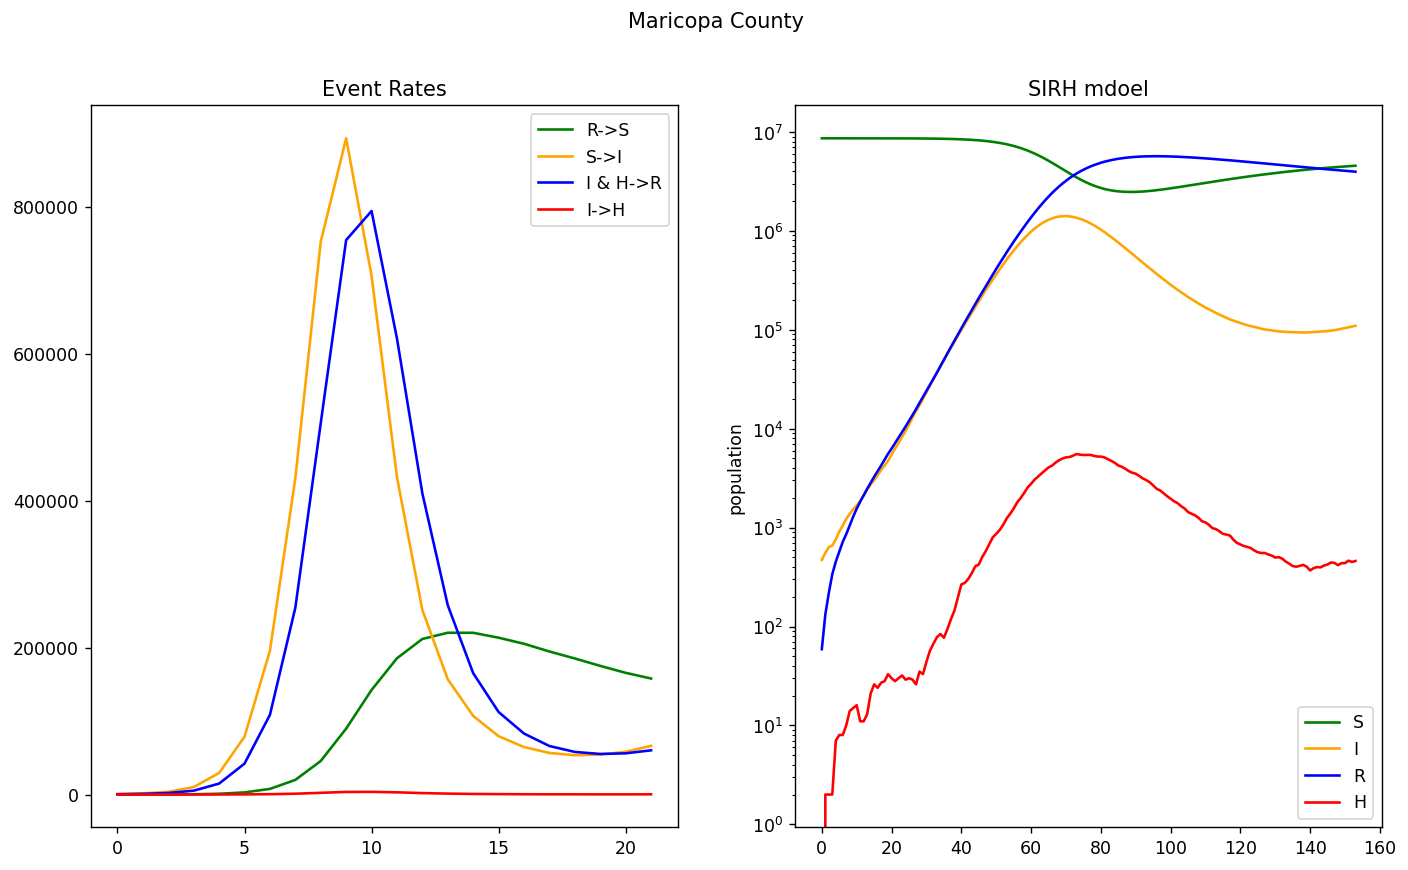

In [43]:
# Get current axis
plot_df.groupby(['ticks']).sum()
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(13.33,7.5), dpi=125)

fig.suptitle('Maricopa County')
sirh = ['S', 'I', 'R', 'H']
sirh_name = ['Susceptible', 'Infected', 'Recovered', 'hospitalized']
event_rate = ['R->S', 'S->I', 'I & H->R', 'I->H' ]
color = ['green', 'orange', 'blue', 'red']

Events = plot_df[['ticks', 'S->I', 'I->R', 'I->H','H->R', 'R->S', 'I & H->R']]
sirh_compartment = plot_df[['ticks', 'S', 'I', 'R', 'H']]
sirh_compartment = sirh_compartment.groupby(sirh_compartment['ticks'] // 2, as_index=False).sum()
Events = Events.groupby(Events['ticks'] // 14, as_index=False).sum()

max_beta = ['average_household_size', 'pop_density_km2', 'beta']
max_gamma = ['gamma', 'median_income', 'tract_gini_index']
# Plots sirh model
for i in range(4):
    sirh_compartment.plot(kind='line',
            y= sirh[i],
            ylabel="population", 
            logy=True,
            color=color[i], 
            ax=axes[1],
            title = 'SIRH mdoel') 
    Events.plot(kind='line', 
            y=event_rate[i],
            color=color[i], 
            ax=axes[0],
            title = 'Event Rates')    
# show the plot
plt.savefig(dir+'/plots/sirh/SIRH_model.png', bbox_inches='tight')
plt.show()

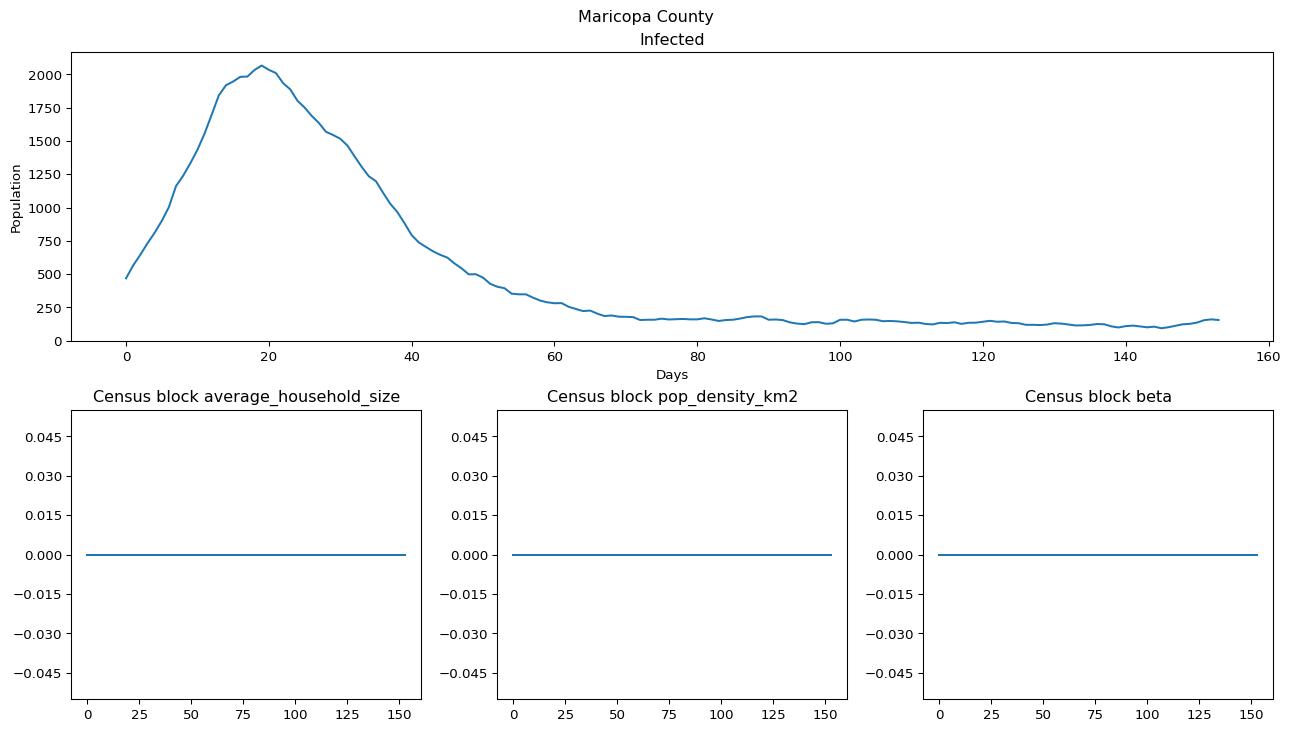

In [18]:
fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(sirh_compartment['I'])
ax0.set_ylabel('Population')
ax0.set_xlabel('Days')
ax0.set_title('Infected')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])
ax12 = fig.add_subplot(spec[1, 2])

# Iterate over census blocks
for i, ax in enumerate([ax10, ax11, ax12]):
    selected_id = geo_df[max_beta[i]].idxmin()  # Manually choose the ID number you want to access

    # Filter the DataFrame to include only rows with the selected tract number
    selected_rows = max_df.loc[max_df['CGB'] == selected_id]

    # Get current axis
    Events_t = selected_rows[['ticks', 'S->I', 'I->R', 'I->H', 'H->R', 'R->S', 'I & H->R']]
    compartment = selected_rows[['ticks', 'S', 'I', 'R', 'H']]
    compartment = compartment.groupby(compartment['ticks'] // 2, as_index=False).sum()
    Events_t = Events_t.groupby(Events_t['ticks'] // 14, as_index=False).sum()

    ax.plot(compartment['H'])
    ax.set_title(f'Census block {max_beta[i]}')

    # Set y-axis ticks to whole numbers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(dir + '/plots/powerpoint/Maricopa_infected_cgb.png', dpi=300, bbox_inches='tight')
plt.show()

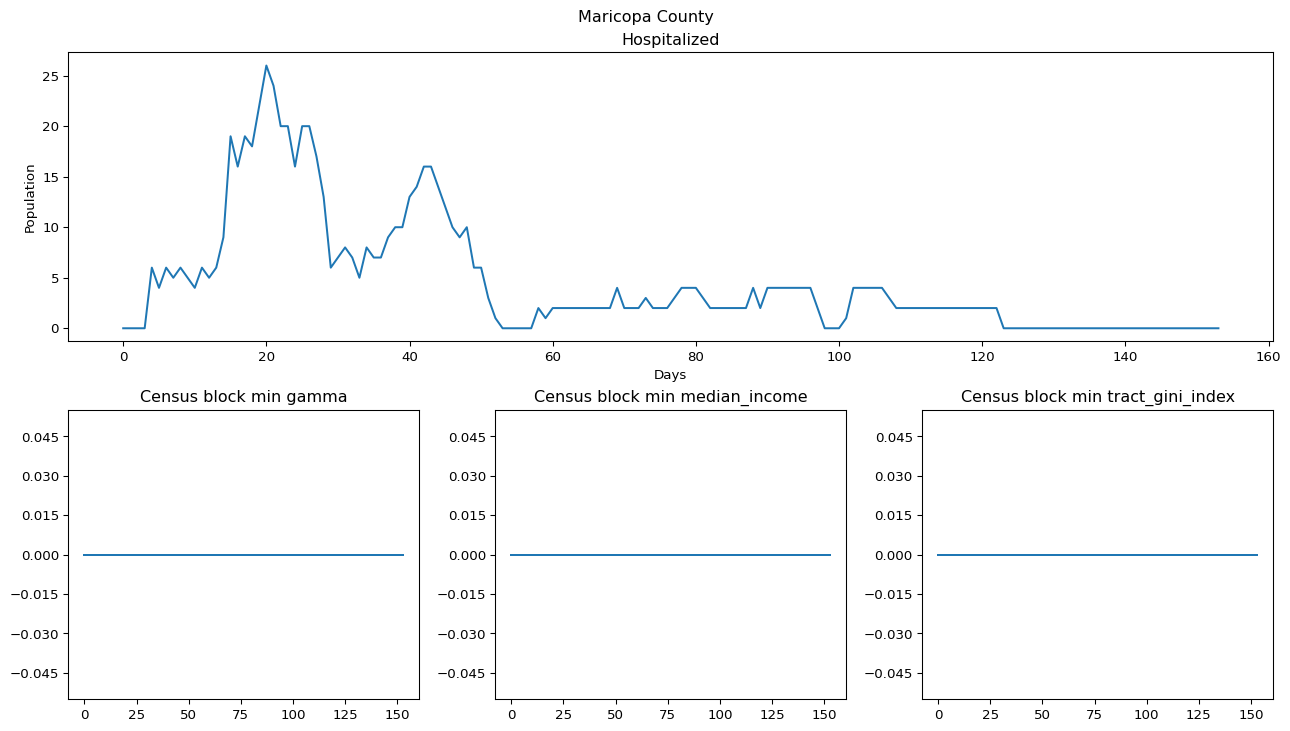

In [19]:

fig = plt.figure(figsize=(13.33, 7.5), dpi=96, constrained_layout=True)
fig.suptitle('Maricopa County')

spec = fig.add_gridspec(2, 3)
ax0 = fig.add_subplot(spec[0, :])
ax0.plot(sirh_compartment['H'])
ax0.set_ylabel('Population')
ax0.set_xlabel('Days')
ax0.set_title('Hospitalized')

# Create subplots for census blocks
ax10 = fig.add_subplot(spec[1, 0])
ax11 = fig.add_subplot(spec[1, 1])
ax12 = fig.add_subplot(spec[1, 2])

# Iterate over census blocks
for i, ax in enumerate([ax10, ax11, ax12]):
    selected_id = sdh_df[max_gamma[i]].idxmax()  # Manually choose the ID number you want to access

    # Filter the DataFrame to include only rows with the selected tract number
    selected_rows = max_df.loc[max_df['CGB'] == selected_id]

    # Get current axis
    Events_t = selected_rows[['ticks', 'S->I', 'I->R', 'I->H', 'H->R', 'R->S', 'I & H->R']]
    compartment = selected_rows[['ticks', 'S', 'I', 'R', 'H']]
    compartment = compartment.groupby(compartment['ticks'] // 2, as_index=False).sum()
    Events_t = Events_t.groupby(Events_t['ticks'] // 2, as_index=False).sum()

    ax.plot(compartment['H'])
    ax.set_title(f'Census block min {max_gamma[i]}')

    # Set y-axis ticks to whole numbers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

plt.savefig(dir + '/plots/powerpoint/Maricopa_hospitalized_cgb.png', dpi=300, bbox_inches='tight')

plt.show()

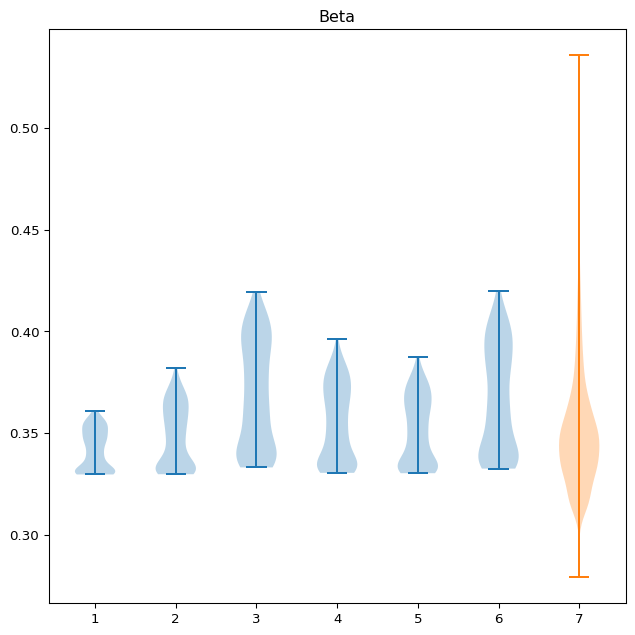

In [22]:
fig = plt.figure(figsize=(6.5,6.5), dpi=96, layout="constrained")
labels = ['FL beta', 'GA beta', 'MD beta','NC beta', 'SC beta', 'VA beta', 'Sim beta' ]
plt.title('Beta')

plt.violinplot(pei)
plt.violinplot(sdh_df['beta'], positions=[7])

plt.savefig(dir + '/plots/powerpoint/beta.png', dpi=300, bbox_inches='tight')           

plt.show()

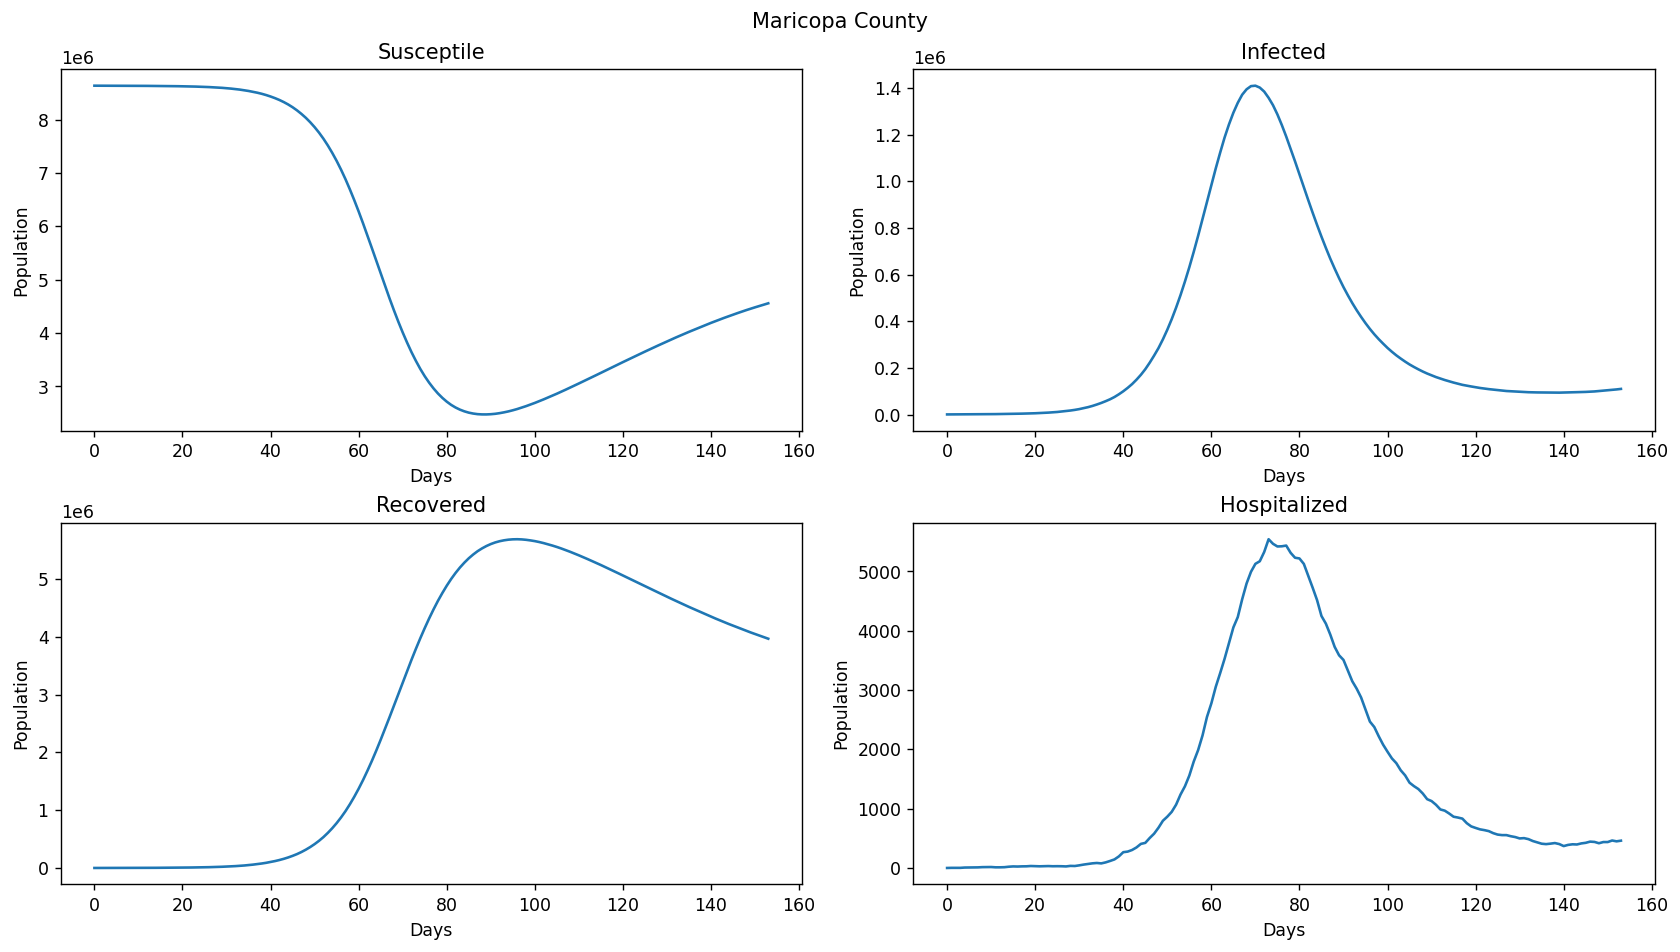

In [23]:
fig = plt.figure(figsize=(13.33,7.5), dpi=125, constrained_layout=True)
fig.suptitle('Maricopa County')

# First subplot
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(compartment_1['S'])
ax1.set_ylabel('Population')
ax1.set_xlabel('Days')
ax1.set_title('Susceptile')

# Second subplot
ax2 = fig.add_subplot(2, 2, 2)
ax2.plot(compartment_2['I'])
ax2.set_ylabel('Population')
ax2.set_xlabel('Days')
ax2.set_title('Infected')

# Third subplot
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(compartment_3['R'])
ax3.set_ylabel('Population')
ax3.set_xlabel('Days')
ax3.set_title('Recovered')

# Fourth subplot
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(compartment_4['H'])
ax4.set_ylabel('Population')
ax4.set_xlabel('Days')
ax4.set_title('Hospitalized')

plt.show()

## Movement models

<Figure size 1666.25x937.5 with 0 Axes>

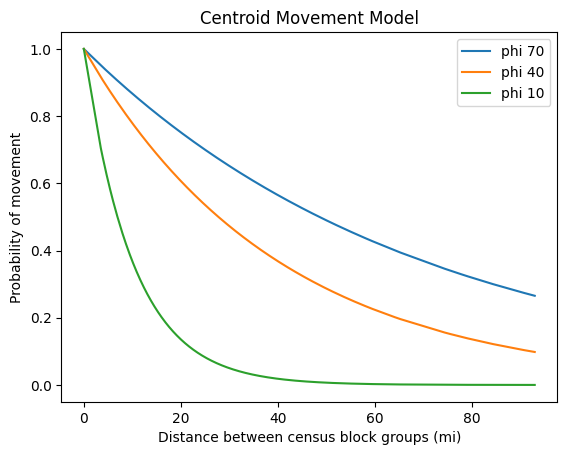

In [24]:
fig = plt.figure(figsize=(13.33,7.5), dpi=125)

fig.suptitle('Centroid Movement Model')
cgb.plot(x='distance',
        ylabel = 'Probability of movement', 
        xlabel = "Distance between census block groups (mi)",
        title = 'Centroid Movement Model')
plt.savefig(dir+'/plots/Movement_model/Centroid_movement.png', bbox_inches='tight')
plt.show()

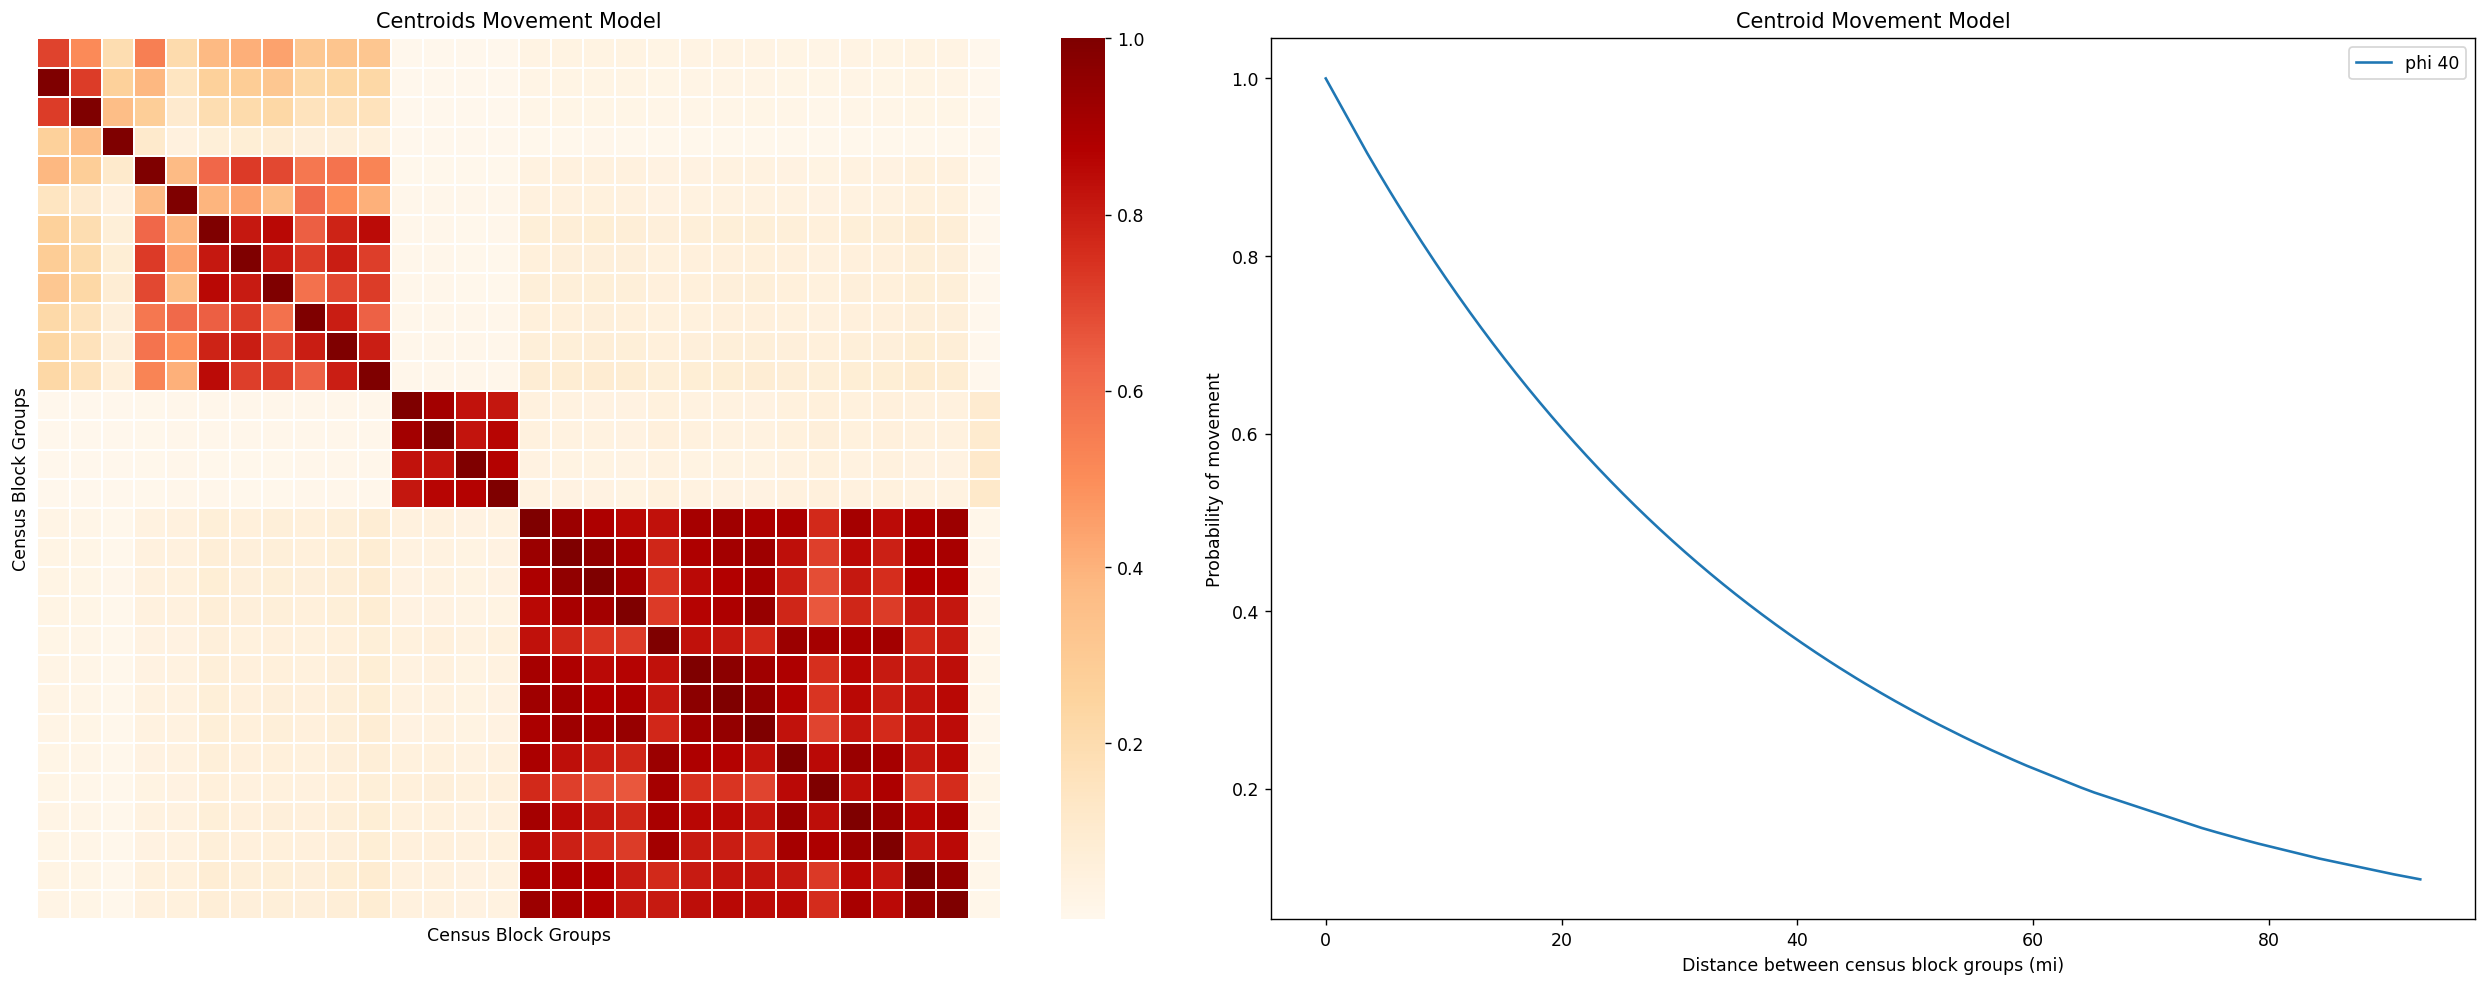

In [25]:
# Load the pairwise distance matrix from the CSV file
dist = pd.read_csv(dir + '/Utility/phi_40.csv', index_col=0)
dist = pd.read_csv(dir + '/Utility/phi_10.csv', index_col=0)

subset = dist.iloc[0:30, 0:30]  # Extract the first 25 rows and 25 columns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 8), dpi=125)

# Plot the heatmap on the first subplot
sns.heatmap(
    subset,
    cmap='OrRd',
    linewidth=0.01,
    ax=ax1
)
ax1.set_ylabel('Census Block Groups')
ax1.set_xlabel('Census Block Groups')
ax1.set_title('Centroids Movement Model')

# Plot the line plot on the second subplot
cgb.plot(x='distance',
         y='phi 40',
         ax=ax2)
ax2.set_ylabel('Probability of movement')
ax2.set_xlabel('Distance between census block groups (mi)')
ax2.set_title('Centroid Movement Model')

# Remove x and y ticks from the heatmap plot
ax1.set_xticks([])
ax1.set_yticks([])

plt.tight_layout()  # Adjust subplot spacing
filename = 'movement_figure.png'
plt.savefig(dir + '/' + filename,bbox_inches='tight')

plt.savefig(dir + '/plots/Movement_model/centriod_and_phi.png', dpi=300, bbox_inches='tight')
plt.show()

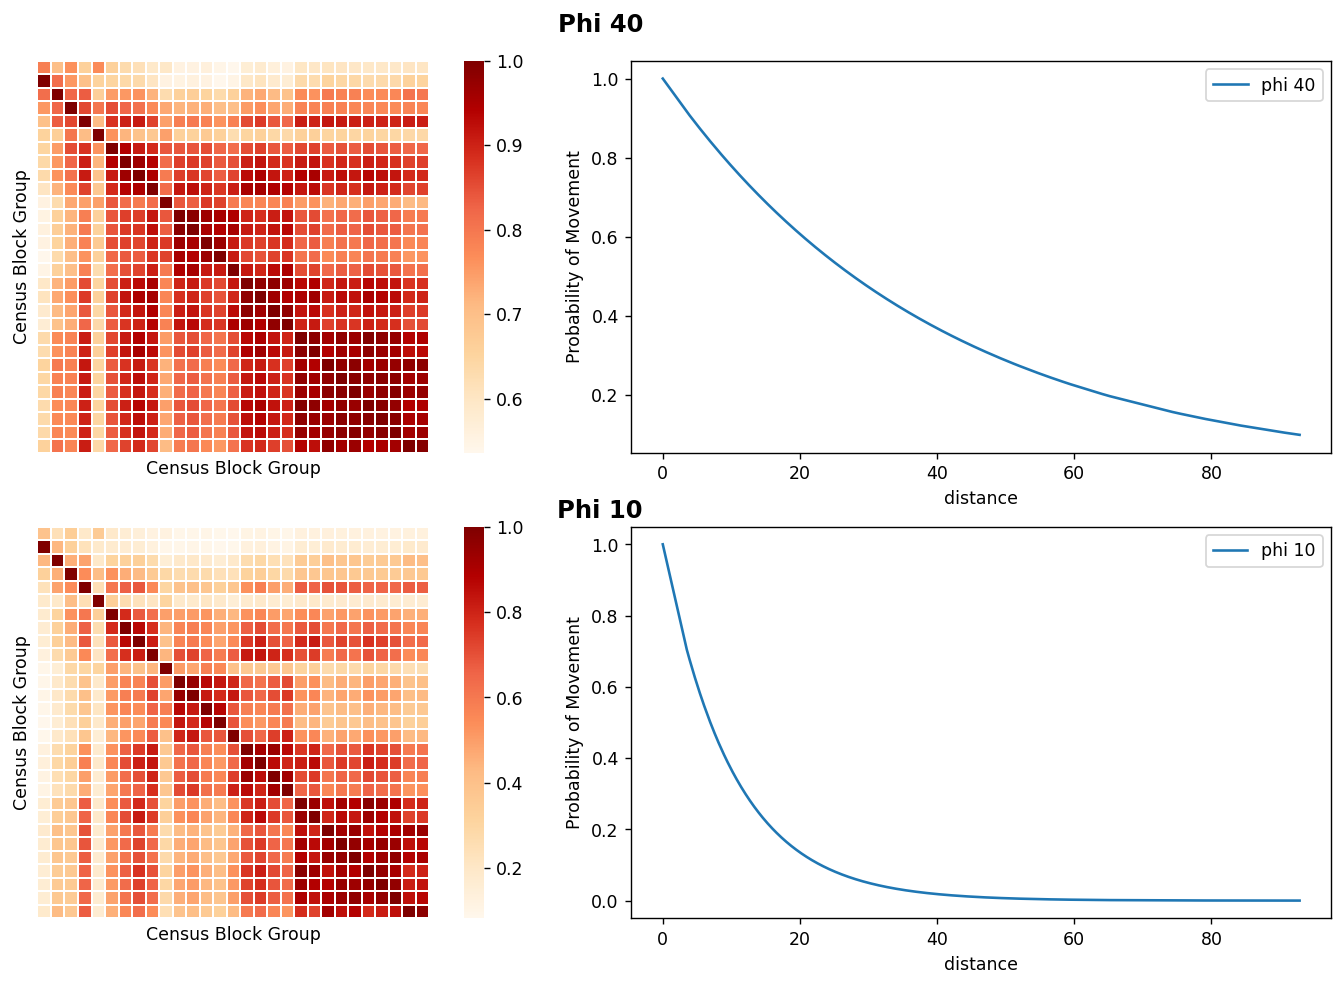

In [26]:
# Load the pairwise distance matrix from the CSV file
dist_phi_40 = pd.read_csv(dir + '/Utility/phi_40.csv', index_col=0)
dist_phi_10 = pd.read_csv(dir + '/Utility/phi_10.csv', index_col=0)

subset_phi_40 = dist_phi_40.iloc[31:60, 31:60]  # Extract the first 25 rows and 25 columns
subset_phi_10 = dist_phi_10.iloc[31:60, 31:60]  # Extract the first 25 rows and 25 columns

# Create the figure and axes
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=125)

# Plot the first heatmap on the top left subplot
sns.heatmap(
    subset_phi_40,
    cmap='OrRd',
    linewidth=0.01,
    ax=axs[0, 0]
)
axs[0, 0].set_ylabel('Census Block Group')
axs[0, 0].set_xlabel('Census Block Group')
axs[0, 0].set_aspect('equal')

# Plot the second heatmap on the bottom left subplot
sns.heatmap(
    subset_phi_10,
    cmap='OrRd',
    linewidth=0.01,
    ax=axs[1, 0]
)
axs[1, 0].set_ylabel('Census Block Group')
axs[1, 0].set_xlabel('Census Block Group')
axs[1, 0].set_aspect('equal')

# Plot the first line plot on the top right subplot
cgb.plot(x='distance',
         y='phi 40',
         ax=axs[0, 1])
axs[0, 1].set_ylabel('Probability of Movement')

# Plot the second line plot on the bottom right subplot
cgb.plot(x='distance',
         y='phi 10',
         ax=axs[1, 1])
axs[1, 1].set_ylabel('Probability of Movement')

# Remove x and y ticks from the heatmaps plots
axs[0, 0].set_xticks([])
axs[0, 0].set_yticks([])
axs[1, 0].set_xticks([])
axs[1, 0].set_yticks([])

# Set a common title for the top row
fig.suptitle('Phi 40', fontsize=14, fontweight='bold')

# Set a common title for the bottom row
fig.text(0.5, 0.475, 'Phi 10', ha='center', fontsize=14, fontweight='bold')

# Adjust subplot spacing and margins
plt.tight_layout()  # Adjust subplot spacing

plt.savefig(dir + '/plots/Movement_model/centriod_and_phi.png', dpi=300, bbox_inches='tight')

plt.show()

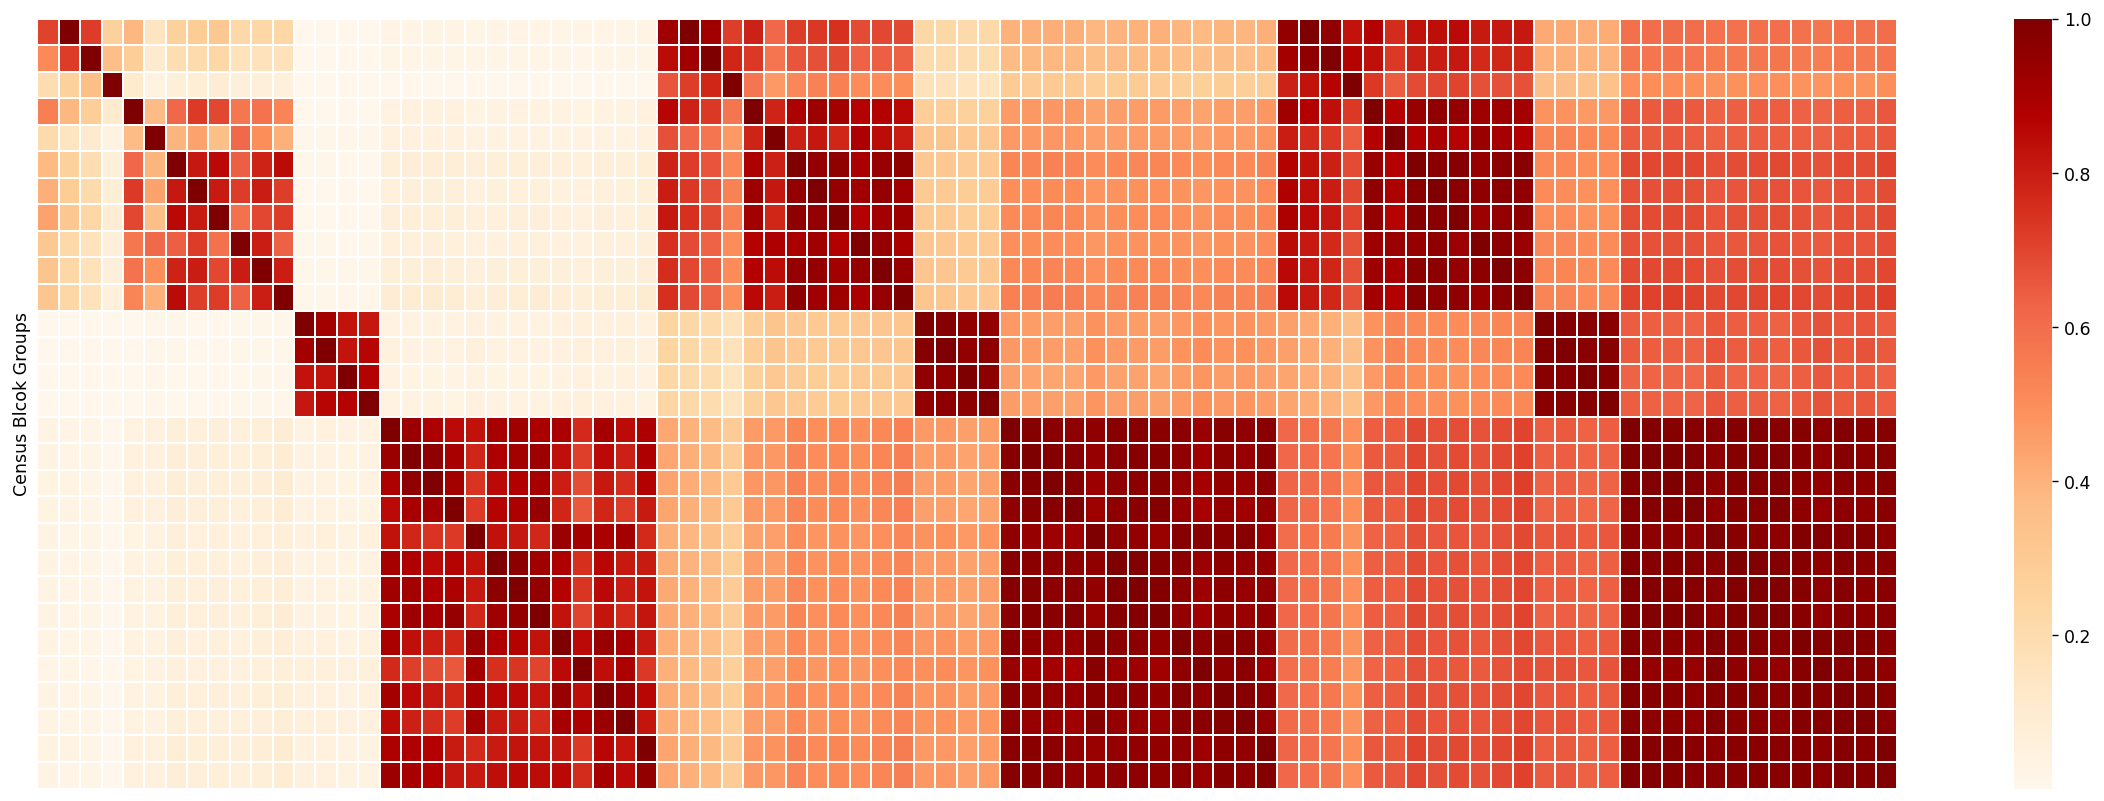

In [27]:
# Load the pairwise distance matrix from the CSV file
phi_10 = pd.read_csv(dir + '/Utility/phi_10.csv', index_col=0)
phi_40 = pd.read_csv(dir + '/Utility/phi_40.csv', index_col=0)
phi_70 = pd.read_csv(dir + '/Utility/phi_70.csv', index_col=0)

phi_10_subset = phi_10.iloc[0:29, 0:29]  # Extract the first 30 rows and 30 columns
phi_40_subset = phi_40.iloc[0:29, 0:29]  # Extract the first 30 rows and 30 columns
phi_70_subset = phi_70.iloc[0:29, 0:29]  # Extract the first 30 rows and 30 columns

phi_subset = [phi_10_subset, phi_40_subset, phi_70_subset]
phi_df = pd.concat(phi_subset, axis =0).T 

plt.figure(figsize=(24, 8), dpi=125)

# Plot the heatmap on the first subplot
sns.heatmap(
    phi_df,
    cmap='OrRd',
    linewidth=0.01,
)
plt.ylabel('Census Blcok Groups')
plt.xlabel('')

plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)

plt.savefig(dir + '/plots/Movement_model/phi_figure.png', bbox_inches='tight')           
# Show the plot
plt.show()

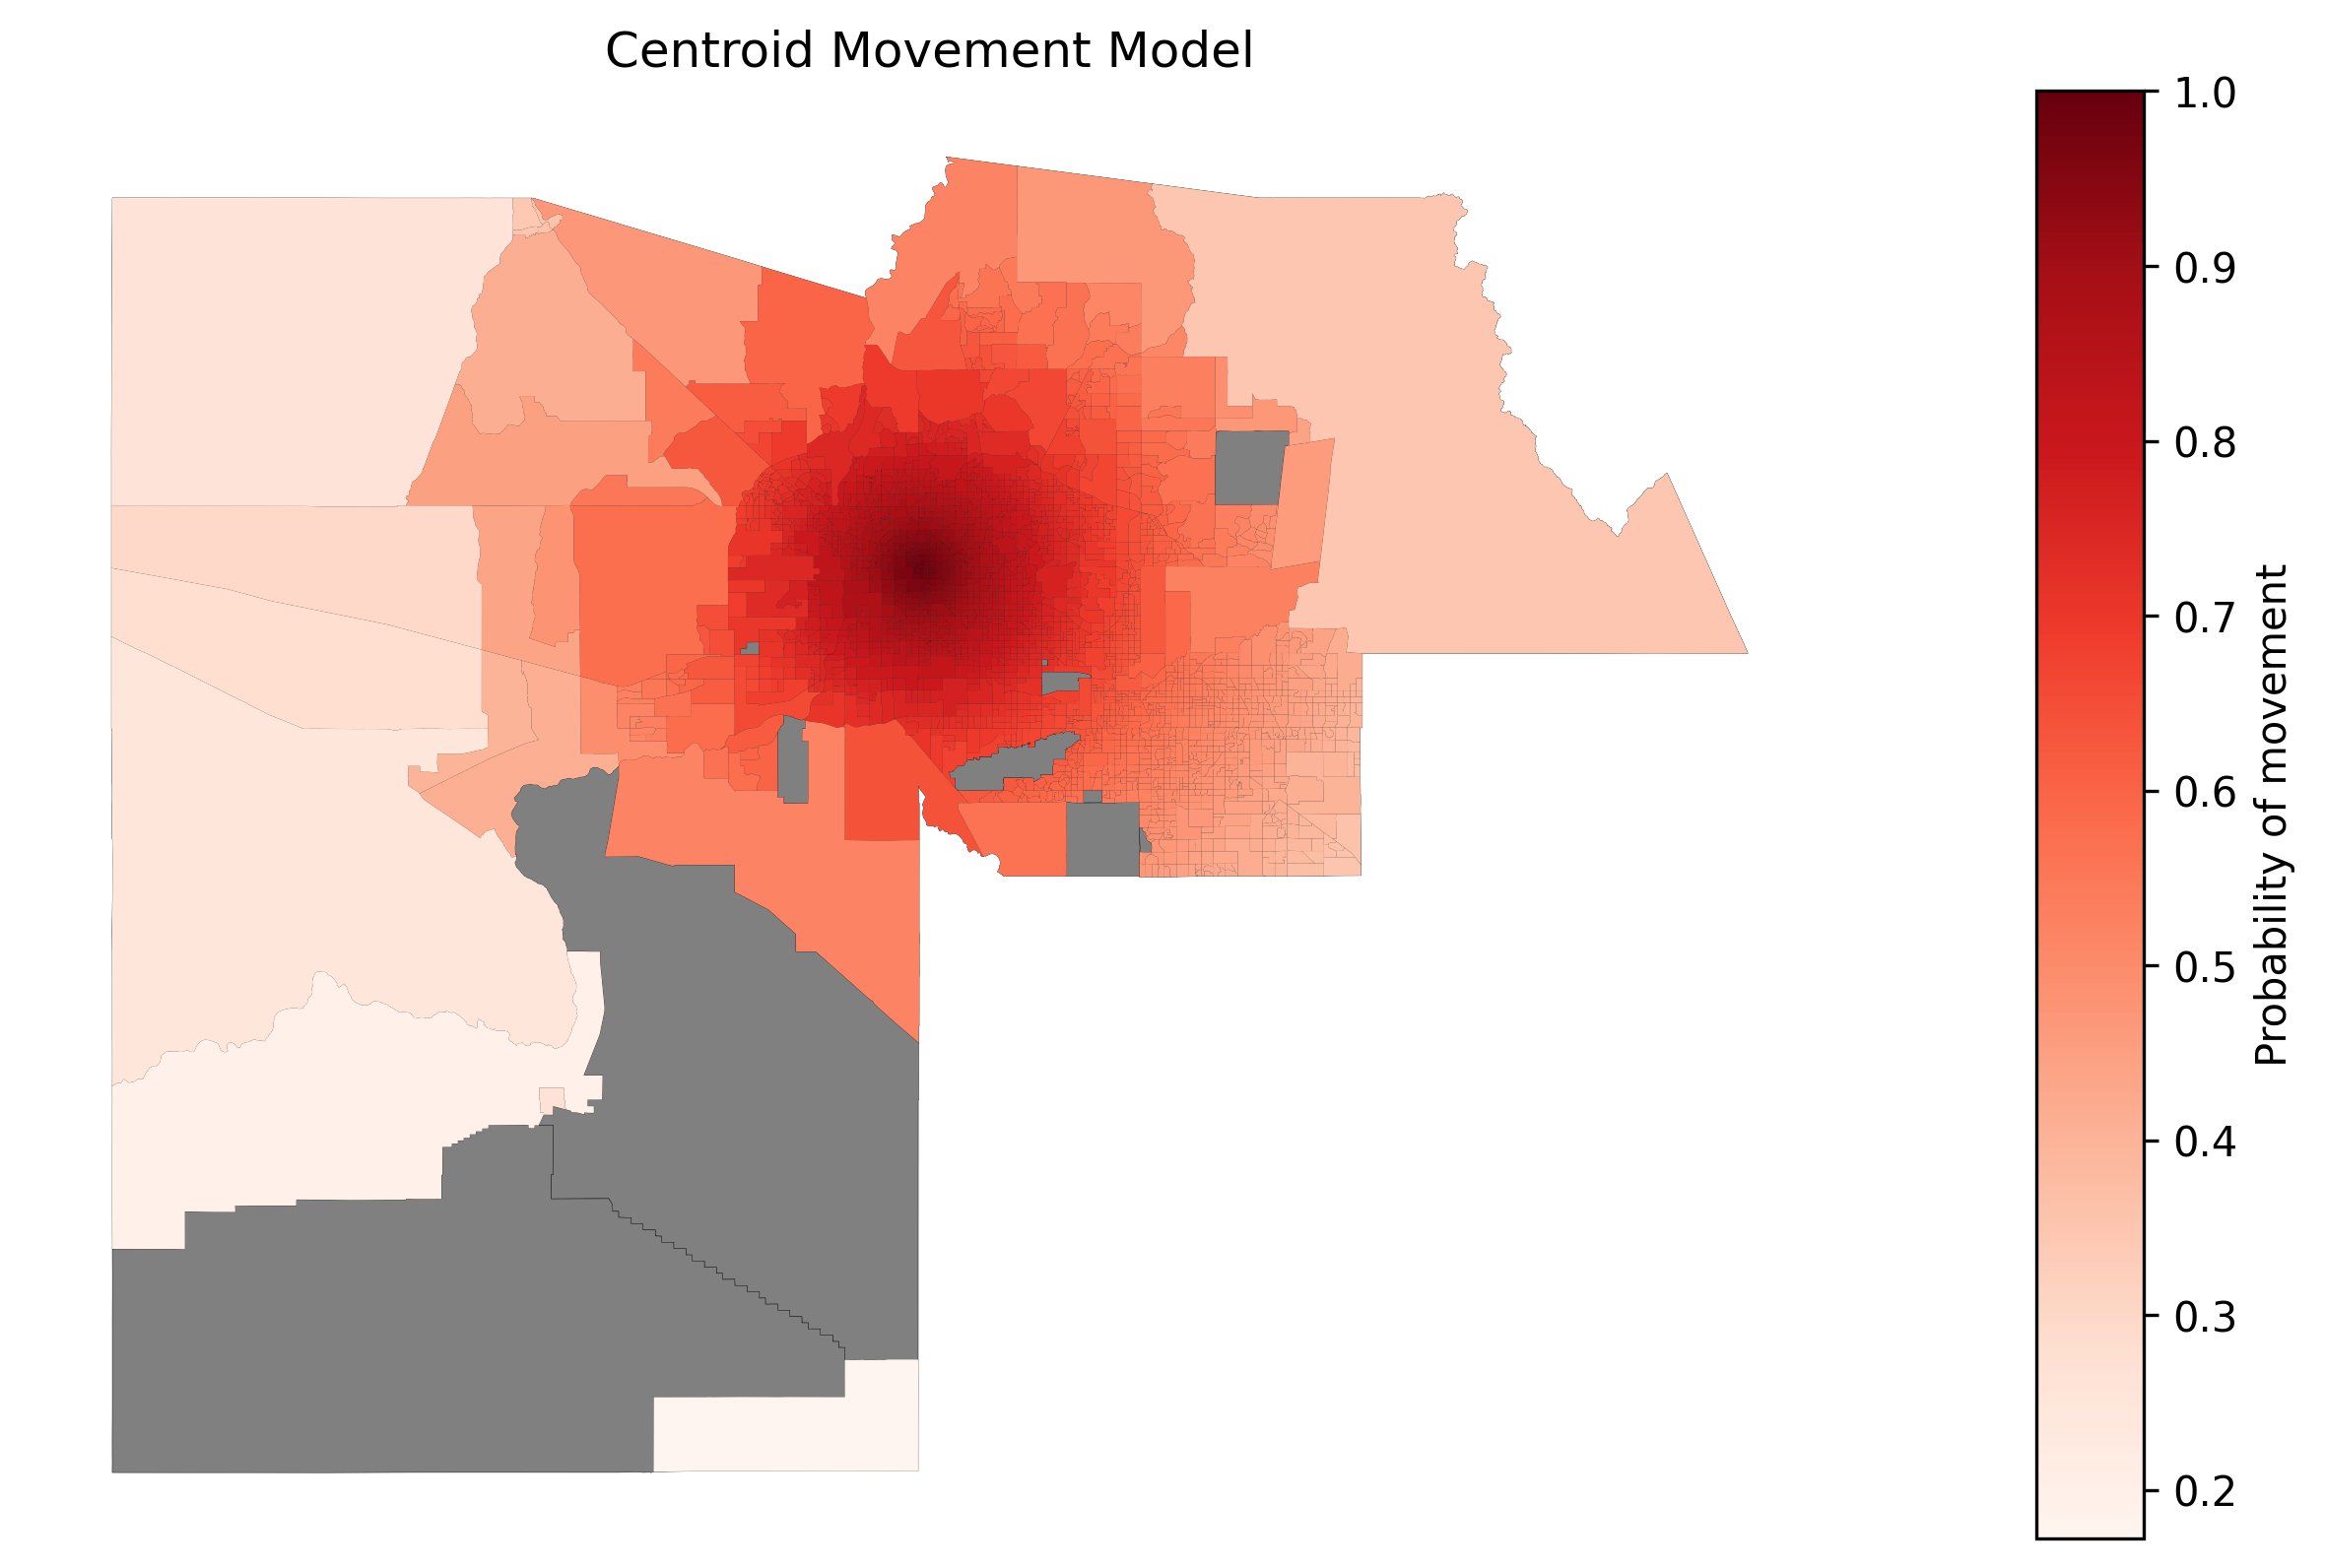

In [30]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)

dot_size = 0.25

# Set up the divider for the colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the map
maricopa_base.plot(
    ax=ax,
    edgecolor='black',
    color='grey',
    linewidth=0.1
)

gpd_df.plot(
    ax=ax,
    edgecolor='black',
    column='phi_40',
    legend=True,
    cmap='Reds', 
    vmin=geo_df['phi_40'].min(),
    vmax=geo_df['phi_40'].max(),
    linewidth=0.005,
    cax=cax,
    legend_kwds={"label": 'Probability of movement', "orientation": "vertical"},
)
'''
for index, row in hospital_locations.iterrows():
    lat = row["latitudes"]
    lon = row["longitudes"]
    ax.scatter(lon, lat, color='black', s=dot_size)
    '''

# Set the title
ax.set_title('Centroid Movement Model')
ax.axis('off')
# Saves map
plt.savefig(dir + '/plots/powerpoint/spatial_distribution_of_movement.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

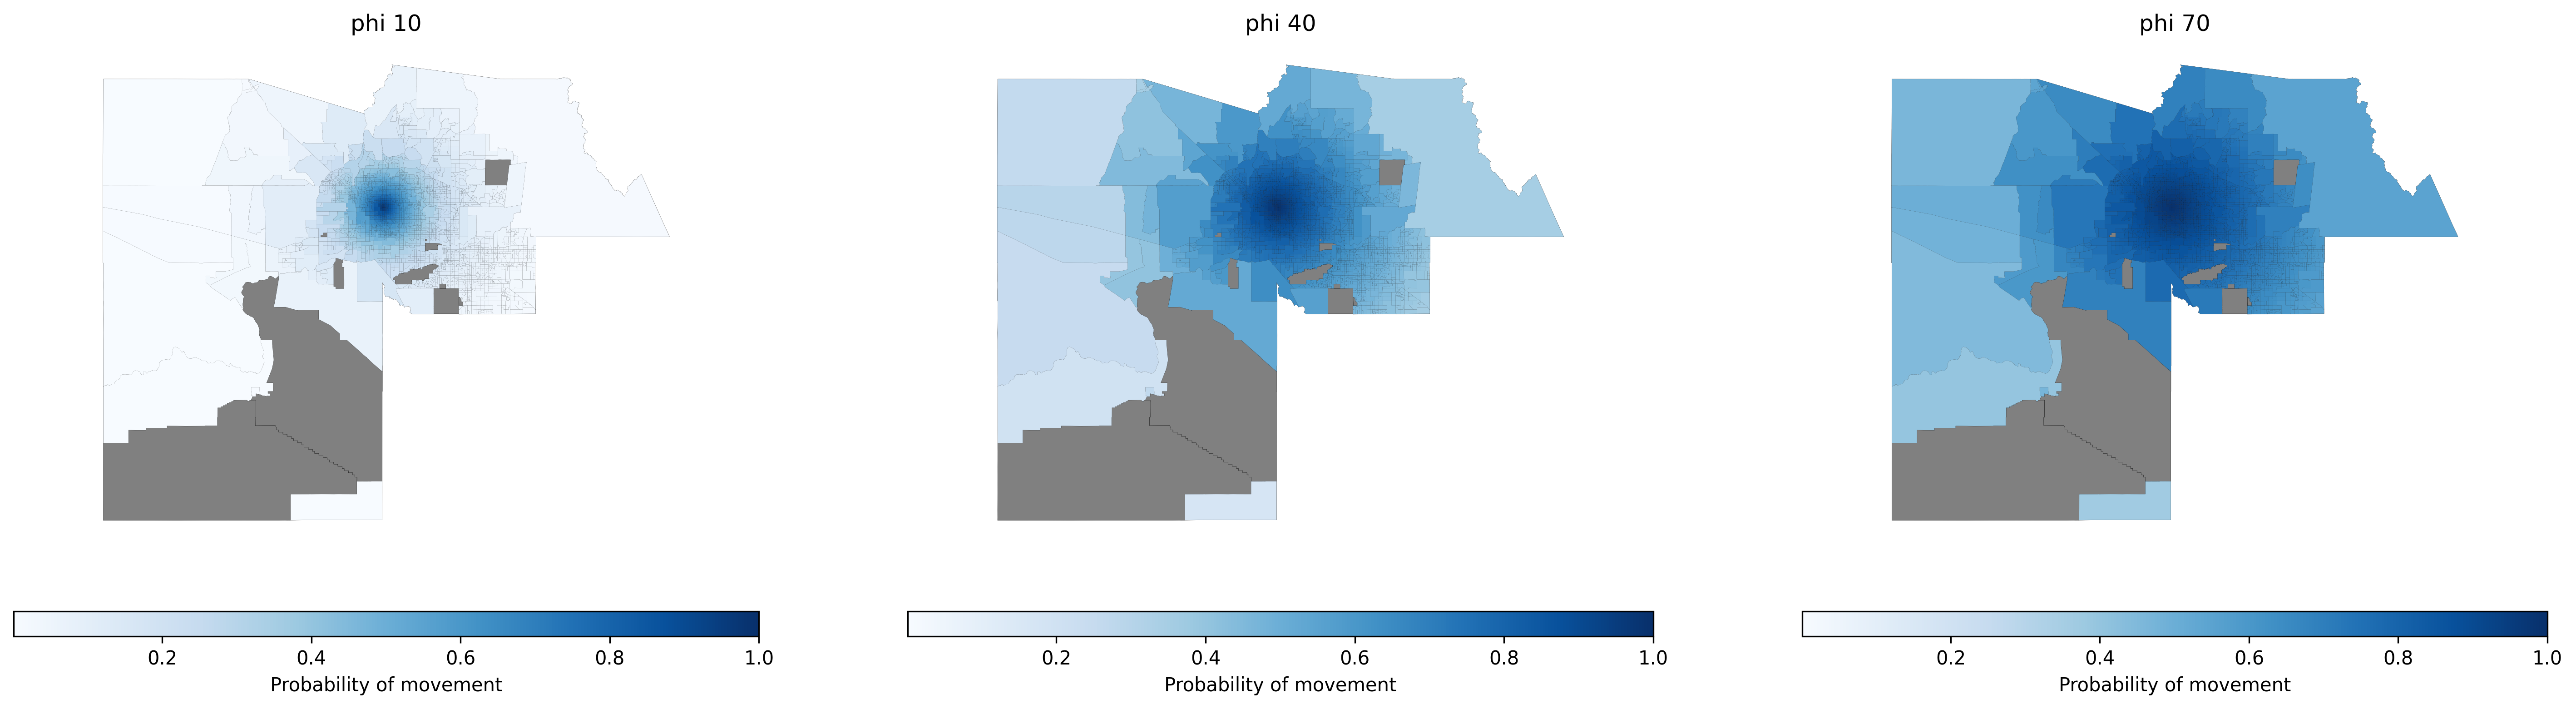

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8), dpi=300)

divider1 = make_axes_locatable(ax1)
divider2 = make_axes_locatable(ax2)
divider3 = make_axes_locatable(ax3)

cax1 = divider1.append_axes("bottom", size="5%", pad=0.5)
cax2 = divider2.append_axes("bottom", size="5%", pad=0.5)
cax3 = divider3.append_axes("bottom", size="5%", pad=0.5)

maricopa_base.plot(
    ax=ax1,
    edgecolor='black',
    color='grey',
    linewidth=0.1
)
gpd_df.plot(
    ax=ax1,
    edgecolor='black',
    column='phi_10',
    legend=True,
    cmap='Blues',
    vmin=geo_df['phi_10'].min(),
    vmax=geo_df['phi_70'].max(),
    linewidth=0.005,
    cax=cax1,
    legend_kwds={"label": 'Probability of movement', "orientation": "horizontal"},
)

maricopa_base.plot(
    ax=ax2,
    edgecolor='black',
    color='grey',
    linewidth=0.1
)
gpd_df.plot(
    ax=ax2,
    edgecolor='black',
    column='phi_40',
    legend=True,
    cmap='Blues',
    vmin=geo_df['phi_10'].min(),
    vmax=geo_df['phi_70'].max(),
    linewidth=0.005,
    cax=cax2,
    legend_kwds={"label": 'Probability of movement', "orientation": "horizontal"},
)

maricopa_base.plot(
    ax=ax3,
    edgecolor='black',
    color='grey',
    linewidth=0.1
)
gpd_df.plot(
    ax=ax3,
    edgecolor='black',
    column='phi_70',  
    legend=True,
    cmap='Blues', 
    vmin=geo_df['phi_10'].min(),  
    vmax=geo_df['phi_70'].max(),
    linewidth=0.005,
    cax=cax3,
    legend_kwds={"label": 'Probability of movement', "orientation": "horizontal"},
)

ax1.set_title('phi 10')
ax2.set_title('phi 40')
ax3.set_title('phi 70')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')

plt.savefig(dir + '/plots/powerpoint/spatial_distribution_of_movement.png', dpi=300, bbox_inches='tight')
plt.show()

## Spatial Distribution 

In [49]:
fnx = ['beta', 'gamma']
scaled_sdh = ['x1','x2']
sdh = ['median_income', 'pop_density_km2', 
        'tract_gini_index', 'average_household_size']
sirh = ['S', 'I', 'R', 'H',]

maps = [*fnx, *scaled_sdh, *sdh, *sirh]
folder = ['fnx/', 'scaled_sdh/', 'sdh/', 'SIRH/']
maps = [*fnx, *scaled_sdh, *sdh, *sirh]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


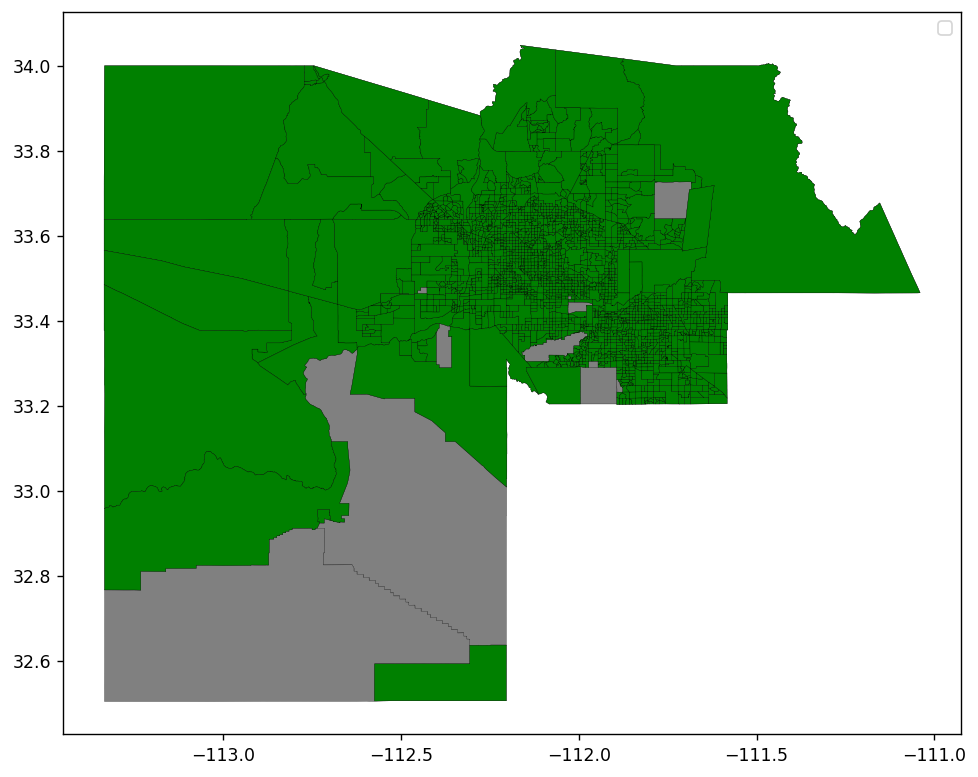

In [44]:
dot_size = 1

fig, ax = plt.subplots(figsize=(13.33, 7.5), dpi=125)

maricopa_base.plot(ax=ax, edgecolor='black', color='grey', linewidth=0.15)
maricopa.plot(ax=ax, edgecolor='black', color='green', linewidth=0.15)



ax.legend()
plt.savefig(dir + '/plots/powerpoint/Maricopa_cgb.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
bin_size = 1

gpd_df['ID'] = np.floor((gpd_df['ID'] - 1) / bin_size) * bin_size + 1
gpd_df['ID'] = gpd_df['ID'].astype(int)
num_groups = len(gpd_df['ID'].unique())

resam_colors = plt.cm.turbo.resampled(num_groups)
colors = [resam_colors(i) for i in np.linspace(0, 1, num=len(gpd_df['ID'].unique()))]
random.shuffle(colors)

fig, ax = plt.subplots(figsize=(13.33, 17.5), dpi=125)

maricopa_base.plot(ax=ax, edgecolor='black', color='grey', linewidth=0.15, label='Maricopa')

legend_elements = []

for group, color in zip(gpd_df['ID'].unique(), colors):
    group_gdf = gpd_df[gpd_df['ID'] == group]
    plot_element = group_gdf.plot(ax=ax, color=color, label=f'Label Group: {group:.0f}')
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=4))

for index, row in hospital_locations.iterrows():
    lat = row["latitudes"]
    lon = row["longitudes"]
    ax.scatter(lon, lat, color='White', s=dot_size)

unique_ids = gpd_df['ID'].unique()
legend_labels = [f'{gpd_df[gpd_df["ID"]==group]["Closest_Hospital"].values[0]}' for group in unique_ids]

plt.title("Hospital Groups")
#ax.legend(legend_elements, legend_labels, title='Hospital', loc='lower right')
plt.xlabel(" ")
plt.ylabel(" ")
ax.axis('off')
plt.show()

In [ ]:
dot_size = 1
bin_size = 1

gpd_df['ID'] = np.floor((gpd_df['ID'] - 1) / bin_size) * bin_size + 1
gpd_df['ID'] = gpd_df['ID'].astype(int)
num_groups = len(gpd_df['ID'].unique())

colors = plt.cm.turbo(np.linspace(0, 1, num=num_groups))

fig, ax = plt.subplots(figsize=(13.33, 17.5), dpi=300)

maricopa_base.plot(ax=ax, edgecolor='black', color='grey', linewidth=0.15, label='Maricopa')

legend_elements = []

for group, color in zip(gpd_df['ID'].unique(), colors):
    group_gdf = gpd_df[gpd_df['ID'] == group]
    plot_element = group_gdf.plot(ax=ax, color=color, label=f'Label Group: {group:.0f}')
    legend_elements.append(plt.Line2D([0], [0], color=color, lw=4))

    for _, row in group_gdf.iterrows():
            ax.text(row['longitudes'], row['latitudes'], str(row['ID']), ha='center', va='center', fontsize=2)
    for _, row in hospital_locations.iterrows():
        center = Point(row['longitudes'], row['latitudes'])
        circle = Circle((center.x, center.y), 1 / 69, edgecolor='black', facecolor='none', lw=0.05)  
        ax.add_patch(circle)

for index, row in hospital_locations.iterrows():
    lat = row["latitudes"]
    lon = row["longitudes"]
    ax.scatter(lon, lat, color='White', s=dot_size)

unique_ids = gpd_df['ID'].unique()
#legend_labels = [hospital_locations[hospital_locations.index.isin(gpd_df[gpd_df['ID'] == group]['Closest_Hospital'])]['Hospital_Name'].values[0] for group in unique_ids]

plt.title("Hospital Groups")
#ax.legend(legend_elements, legend_labels, title='Hospital', loc='lower right')

#ax.legend(legend_elements, legend_labels, title='Hospital', loc='lower right')
plt.xlabel(" ")
plt.ylabel(" ")
ax.axis('off')
plt.show()


In [ ]:
table_1 = [
    [closest_hospitals_df['Closest_Hospital'].unique()[0], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[0])].count()['count'], hospital_df['total_beds_7_day_sum'][0], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[1], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[1])].count()['count'], hospital_df['total_beds_7_day_sum'][1] , ' '],
    [closest_hospitals_df['Closest_Hospital'].unique()[2], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[2])].count()['count'], hospital_df['total_beds_7_day_sum'][2], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[3], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[3])].count()['count'], hospital_df['total_beds_7_day_sum'][3], ],
    [closest_hospitals_df['Closest_Hospital'].unique()[4], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[4])].count()['count'], hospital_df['total_beds_7_day_sum'][4], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[5], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[5])].count()['count'], hospital_df['total_beds_7_day_sum'][5], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[6], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[6])].count()['count'], hospital_df['total_beds_7_day_sum'][6], ' '],
    [closest_hospitals_df['Closest_Hospital'].unique()[7], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[7])].count()['count'], hospital_df['total_beds_7_day_sum'][7], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[8], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[8])].count()['count'], hospital_df['total_beds_7_day_sum'][8], ' '],
    [closest_hospitals_df['Closest_Hospital'].unique()[9], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[9])].count()['count'], hospital_df['total_beds_7_day_sum'][9], '' ],
    [closest_hospitals_df['Closest_Hospital'].unique()[10], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[10])].count()['count'], hospital_df['total_beds_7_day_sum'][10], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[11], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[11])].count()['count'], hospital_df['total_beds_7_day_sum'][11], ' '],
    [closest_hospitals_df['Closest_Hospital'].unique()[12], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[12])].count()['count'], hospital_df['total_beds_7_day_sum'][12], ''],
    [closest_hospitals_df['Closest_Hospital'].unique()[13], gpd_df.loc[(gpd_df['Closest_Hospital'] == closest_hospitals_df['Closest_Hospital'].unique()[13])].count()['count'], hospital_df['total_beds_7_day_sum'][13], ],
]

column_head_1 = ['Hospitals', 'Total Census Block Groups in area', 'Total beds', 'Something else ']

df = pd.DataFrame(table_1, columns=column_head_1)

fig, ax = plt.subplots(figsize=(8, 5))

ax.axis('off')

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.25, 2.25)

table[0, 0].get_text().set_weight('bold')
table[0, 1].get_text().set_weight('bold')
table[0, 2].get_text().set_weight('bold')
table[0, 3].get_text().set_weight('bold')

table.auto_set_column_width([0, 1, 2, 3]) 
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

plt.savefig('table.png', bbox_inches='tight', dpi=300)
plt.show()

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/fnx/beta.png


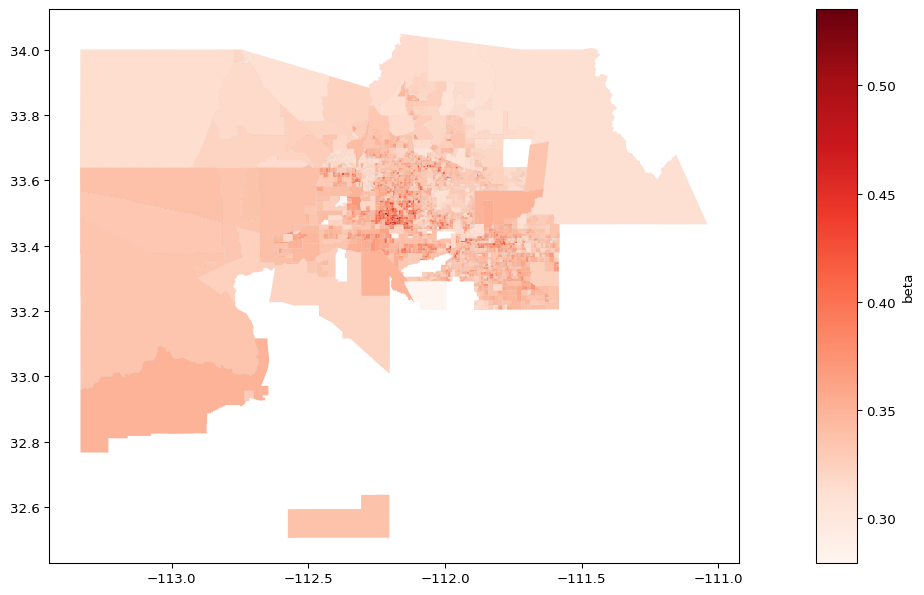

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/fnx/gamma.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/scaled_sdh/x1.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/scaled_sdh/x2.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/sdh/median_income.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/sdh/pop_density_km2.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/sdh/tract_gini_index.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/sdh/average_household_size.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/SIRH/S.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/SIRH/I.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/SIRH/R.png


<Figure size 640x480 with 0 Axes>

/Users/alexandernez/Desktop/Github/Epymorph/scratch/plots/SIRH/H.png


<Figure size 640x480 with 0 Axes>

In [66]:
fnx = ['beta', 'gamma']
scaled_sdh = ['x1','x2']
sdh = ['median_income', 'pop_density_km2', 
        'tract_gini_index', 'average_household_size']
sirh = ['S', 'I', 'R', 'H',]

maps = [*fnx, *scaled_sdh, *sdh, *sirh]
folder = ['fnx/', 'scaled_sdh/', 'sdh/', 'SIRH/']
maps = [*fnx, *scaled_sdh, *sdh, *sirh]

fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=96)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

for i in range(len(maps)):
    gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = maps[i], 
        legend = True, 
        cmap='Reds',
        vmin = geo_df[maps[i]].min(), 
        vmax = geo_df[maps[i]].max(),
        linewidth = 0.01,
        cax=cax,
        legend_kwds={"label": maps[i], "orientation": "vertical"},
        )
    png = str(maps[i])
    sim_maps = str(maps[i])

    if png in fnx:
        path = str(folder[0])
    elif png in str(scaled_sdh):
        path = folder[1]
    elif png in sdh:
        path = str(folder[2])
    else:
        path = str(folder[3])
    print(f"{dir}/plots/{path}{sim_maps}.png")
    plt.savefig(f"{dir}/plots/{path}/{sim_maps}.png", bbox_inches='tight')
    plt.show()

In [17]:
list(gpd_df.columns.values.tolist())

['index',
 'STATEFP10',
 'COUNTYFP10',
 'TRACTCE10',
 'BLKGRPCE10',
 'GEOID10',
 'NAMELSAD10',
 'MTFCC10',
 'FUNCSTAT10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'geometry',
 'labels',
 'population',
 'centroid',
 'median_age',
 'pop_by_age',
 'median_income',
 'total_income',
 'average_household_size',
 'pop_density_km2',
 'tract_median_income',
 'tract_gini_index',
 'count',
 'gamma',
 'gamma 0',
 'x1',
 'x2',
 'min_x1',
 'min_x2',
 'beta',
 'basis_beta',
 'alpha 0',
 'alpha 1',
 'alpha 2',
 'Closest_Hospital',
 'ID',
 'CGB',
 'S',
 'I',
 'R',
 'H',
 'S->I',
 'I->R',
 'I->H',
 'H->R',
 'R->S',
 'I & H->R',
 'longitudes',
 'latitudes',
 'average_household_size_phi',
 'pop_density_km2_phi',
 'beta_phi',
 'gamma_phi',
 'median_income_phi',
 'tract_gini_index_phi',
 'phi_40',
 'phi_10',
 'phi_70']

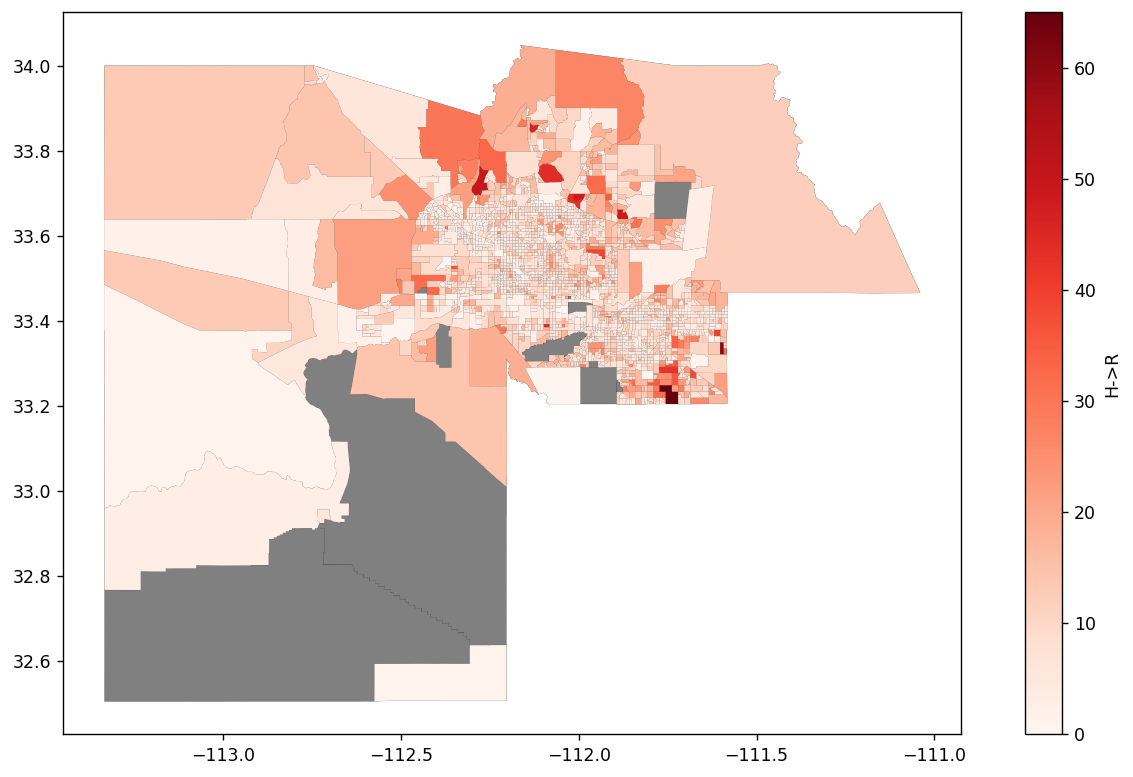

In [22]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=125)

maricopa_base.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

sim_maps = 'H->R'

gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = sim_maps, 
        legend = True, 
        cmap='Reds',
        vmin = gpd_df[sim_maps].min(), 
        vmax = gpd_df[sim_maps].max(),
        linewidth = 0.01,
        legend_kwds={"label": sim_maps, "orientation": "vertical"},
        )

plt.savefig(f"{dir}/plots/powerpoint/{sim_maps}.png", bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=96)
minx, miny, maxx, maxy = [-112.5, 33.8, -111.8, 33.2]

ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

maricopa_base.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

for i in range(len(maps)):
    gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = maps[i], 
        legend = True, 
        cmap='Blues',
        vmin = geo_df[maps[i]].min(), 
        vmax = geo_df[maps[i]].max(),
        linewidth = 0.01,
        cax=cax,
        legend_kwds={"label": maps[i], "orientation": "vertical"},
        )
    png = str(maps[i])
    sim_maps = str(maps[i])

    if png in fnx:
        path = str(folder[0])
    elif png in str(scaled_sdh):
        path = folder[1]
    elif png in sdh:
        path = str(folder[2])
    else:
        path = str(folder[3])
    

    plt.savefig(dir+ '/plots/zoom/' + path + '/' + sim_maps + '.png', bbox_inches='tight')
    plt.close()

In [ ]:
title1 = "Spatial Distribution of Hospitalized in Maricopa"
title2 = "Spatial Distribution of Hospitalization Rate in Maricopa"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=96)
minx, miny, maxx, maxy = [-112.5, 33.8, -111.8, 33.2]

# Set limits for both axes
ax1.set_xlim(minx, maxx)
ax1.set_ylim(miny, maxy)
ax2.set_xlim(minx, maxx)
ax2.set_ylim(miny, maxy)

# Create colorbar axes
divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)

maricopa_base.plot(ax=ax1, edgecolor='black', color='grey', linewidth=0.01)


# Plot first map on ax1
gpd_df.plot(ax=ax1, edgecolor='black', column='H', legend=True, cmap='Reds',
                vmin=geo_df['H'].min(), vmax=geo_df['H'].max(), linewidth=0.001,
                cax=cax1, legend_kwds={"label": 'Hospitalized', "orientation": "vertical"})

ax1.set_title(title1)  # Set the title for the first map

# Plot second map on ax2
maricopa.plot(ax=ax2, edgecolor='black', color='grey', linewidth=0.01)
gpd_df.plot(ax=ax2, edgecolor='black', column='gamma', legend=True, cmap='Reds',
                vmin=geo_df['gamma'].min(), vmax=geo_df['gamma'].max(), linewidth=0.001,
                cax=cax2, legend_kwds={"label": 'Hospitalization Rate', "orientation": "vertical"})

ax2.set_title(title2)  # Set the title for the second map

plt.savefig(dir + '/plots/powerpoint/Spatial_distribution_for_H.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=96)

# Set limits for the axes
minx, miny, maxx, maxy = [-112.5, 33.8, -111.8, 33.2]
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Create colorbar axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Plot the map on the single axes
maricopa_base.plot(ax=ax, edgecolor='black', color='grey', linewidth=0.01)
gpd_df.plot(ax=ax, edgecolor='black', column='beta', legend=True, cmap='viridis',
            vmin=geo_df['beta'].min(), vmax=geo_df['beta'].max(), linewidth=0.001,
            cax=cax, legend_kwds={"label": 'Infected', "orientation": "vertical"})

ax.set_title(title1)  # Set the title for the map

plt.savefig(dir + '/plots/powerpoint/zoom_spatial_distribution.png', dpi=300, bbox_inches='tight')

plt.show()

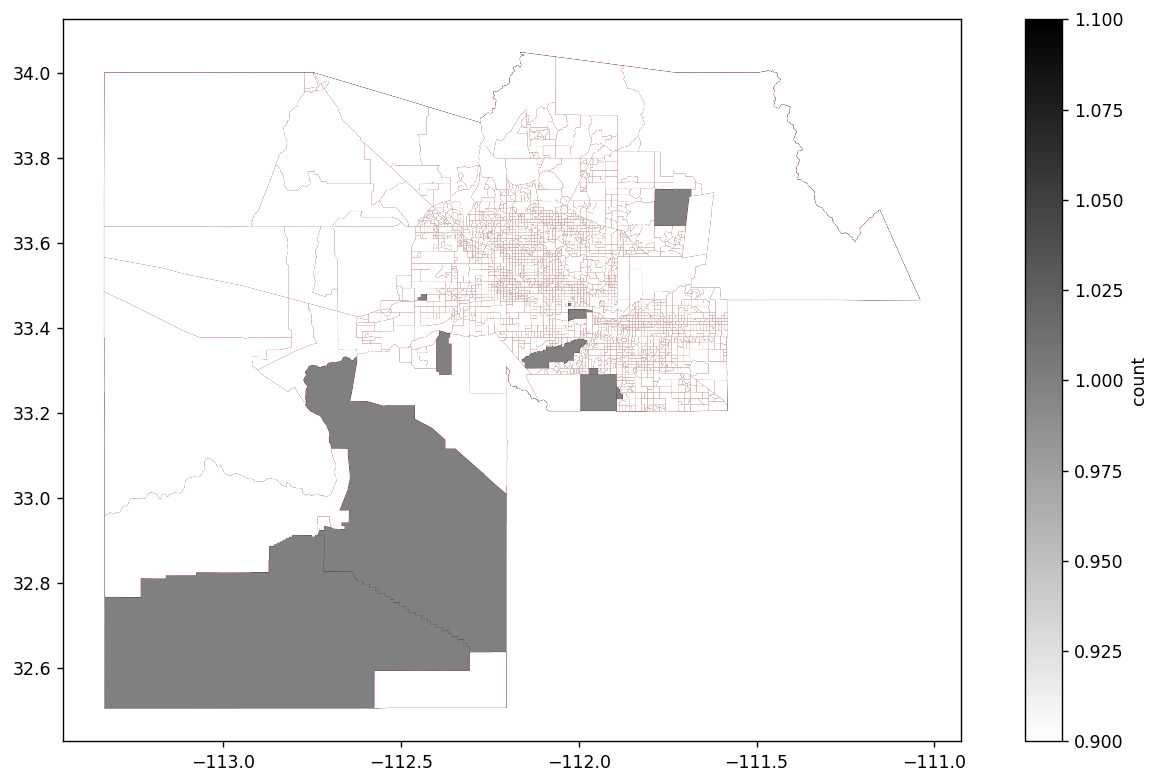

In [70]:
fig, ax = plt.subplots(figsize=(13.33,7.5), dpi=125)

maricopa_base.plot(ax = ax, edgecolor='black',color='grey', linewidth = 0.1)

maricopa.plot(ax = ax, edgecolor='black',color='red', linewidth = 0.15)
gpd_df.plot(
        ax = ax, 
        edgecolor = 'black', 
        column = 'count', 
        legend = True, 
        cmap='gist_yarg',
        linewidth = 0.01,
        legend_kwds={"label": 'count', "orientation": "vertical"},
        )
plt.savefig(dir + '/plots/powerpoint/data_cleaning.png', dpi=300, bbox_inches='tight')
plt.show()

## AZ flu data
·        total_patients_hospitalized_confirmed_influenza_7_day_avg

·        total_patients_hospitalized_confirmed_influenza_7_day_sum

·        total_patients_hospitalized_confirmed_influenza_7_day_coverage

·        previous_day_admission_influenza_confirmed_7_day_sum

In [ ]:
# Get the epi weeks starting from Epi Week 40
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))  # Adjusted the end value to include 40

# Format the tick labels as "Epi week n"
custom_tick_labels = [*epi_weeks_40_52, *epi_weeks_1_40]

# Set the x-axis tick positions and labels
epi_weeks_40_52 = list(range(40, len(flu_grouped) + 13))
epi_weeks_1_40 = list(range(1, 41))
xtick_positions = [*epi_weeks_40_52, *epi_weeks_1_40]
xtick_labels = ['Epi week {}'.format(i) for i in xtick_positions]

In [ ]:
fig = plt.figure(figsize=(30, 7.5), dpi=96, constrained_layout=True)

spec = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax10 = fig.add_subplot(spec[0, 1])
ax11 = fig.add_subplot(spec[1, 0])
ax12 = fig.add_subplot(spec[1, 1])

ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'],label= '7 day coverage')
ax0.plot(flu_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],label= 'Influenza 7 day sum')
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'], label= 'Hospitalized 7 day avg')
ax0.plot(flu_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'], label= 'Hospitalized 7 day sum')

# Use modulo operator to wrap the x-axis values between 40 and 52
ax0.set_xticks(range(len(xtick_labels)))
ax0.set_xticklabels(xtick_labels, rotation='vertical')

ax0.set_ylabel('Cases')
ax0.set_xlabel(' ')
ax0.set_title('Flu Data by Epi Weeks')
ax0.legend()

# Create subplots for census blocks

ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])

ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],'o',color = 'teal', label = "collection_week")
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'],'o',color = 'teal')
ax10.plot(hospital_1_grouped['collection_week'], hospital_1_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'],'o',color = 'teal')

line1, = ax10.plot(flu_grouped['collection_week'], flu_grouped['count'], color = 'white')
line1.remove()

ax10.set_ylabel('Cases')
ax10.set_xlabel('Collection weeks')
ax10.set_title('BANNER - UNIVERSITY MEDICAL CENTER PHOENIX')
ax10.legend()

ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])

ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],'o',color = 'teal', label = "collection_week")
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'],'o',color = 'teal')
ax11.plot(hospital_2_grouped['collection_week'], hospital_2_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'],'o',color = 'teal')

line2, = ax11.plot(flu_grouped['collection_week'], flu_grouped['count'], color = 'white')
line2.remove()

ax11.set_ylabel('Cases')
ax11.set_xlabel('Collection weeks')
ax11.set_title('VALLEYWISE HEALTH MEDICAL CENTER')
ax11.legend()

ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_coverage'])
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum'])
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'])
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'])

ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['previous_day_admission_influenza_confirmed_7_day_sum'],'o',color = 'teal', label = "collection_week")
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_avg'],'o',color = 'teal')
ax12.plot(hospital_3_grouped['collection_week'], hospital_3_grouped['total_patients_hospitalized_confirmed_influenza_7_day_sum'],'o',color = 'teal')

line3, = ax12.plot(flu_grouped['collection_week'], flu_grouped['count'], color = 'white')
line3.remove()

ax12.set_ylabel('Cases')
ax12.set_xlabel('Collection weeks')
ax12.set_title('ABRAZO ARROWHEAD CAMPUS')
ax12.legend()

plt.savefig(dir + '/plots/Az_data/agg_data.png', dpi=300, bbox_inches='tight')
plt.show()


# Spline

### Basis Function:
A basis function is a mathematical function used in various fields, especially in linear algebra and numerical analysis. It plays a fundamental role in expressing more complex functions as linear combinations of simpler functions. In the context of function approximation or interpolation, basis functions are used to represent a wide range of functions using a finite set of basis functions.

For example, in polynomial interpolation, the basis functions could be the monomials 1, x, x^2, x^3, ..., and any polynomial function can be represented as a linear combination of these basis functions.

### Spline:
A spline is a piecewise-defined function used for interpolation or approximation of data points. It is commonly used in computer graphics, computer-aided design (CAD), and various other fields where smooth curves are needed. Spline interpolation involves constructing a smooth curve that passes through a given set of data points. The curve is created by connecting multiple polynomial segments (usually cubic) in such a way that they join smoothly at shared data points.

Cubic splines are particularly common, where a cubic polynomial is defined for each interval between adjacent data points. These polynomials are constrained to ensure the spline is smooth (continuous and with continuous derivatives up to a certain order) at the data points. This results in a visually pleasing and mathematically well-behaved curve that captures the overall shape of the data.

Splines are often used to create smooth paths in computer graphics, design smooth curves in engineering applications, and accurately represent data while avoiding the issues of high-degree polynomials.

## Function used for basis function 

In [ ]:
def cox_de_boor(u, i, k, t):
    """ Evaluates the Cox-de Boor recursion formula. """
    if k == 0:
        return 1.0 if t[i] <= u < t[i+1] else 0.0
    else:
        term1 = 0.0
        term2 = 0.0
        
        if (t[i + k] - t[i]) != 0:
            term1 = ((u - t[i]) / (t[i + k] - t[i])) * cox_de_boor(u, i, k-1, t)
            
        if (t[i + k + 1] - t[i+1]) != 0:
            term2 = ((t[i + k + 1] - u) / (t[i + k + 1] - t[i + 1])) * cox_de_boor(u, i+1, k-1, t)
        
        return term1 + term2

# Define the knot vector and the degree
knot_vector = [0, 0, 0, 0, 1, 2, 3, 3, 3, 3] 
degree = 3

# Generate a range of u values for plotting
u_vals = np.linspace(knot_vector[0], knot_vector[-1], 1000)

# Plot each B-spline basis function
for i in range(len(knot_vector) - degree - 1):
    N = [cox_de_boor(u, i, degree, knot_vector) for u in u_vals]
    plt.plot(u_vals, N, label=f'N_{i},{degree}')

plt.title("Cubic B-spline Basis Functions")
plt.xlabel("u")
plt.ylabel("Basis Function Value")
plt.legend(loc='upper right')
plt.show()

In [ ]:
cgb_1 = 425
cgb_2 = 42

knot_vector = np.arange(0, 49, 7)
degree = 3
knot_length = len(knot_vector)

u_vals = np.linspace(knot_vector[0], knot_vector[-1], 150)

N = np.zeros((len(u_vals), knot_length - degree - 1))

for i in range(knot_length - degree - 1):
    for j, u in enumerate(u_vals):
        N[j, i] = cox_de_boor(u, i, degree, knot_vector)

coefficients = np.array([0, 0.03, 0.01, 0.03, # Octobet
                  0.35, 0.37, 0.46, 0.53, 0.51, # November
                  0.52, 0.49, 0.47, 0.44, # December
                  0, 0, 0, 0, # January
                  0, 0, 0, 0, # February 
                  0, 0, 0, 0, # March
                  0, 0, 0, 0, 0, # April
                  0, 0, 0, 0, # May
                  0, 0, 0, 0, 0, # June
                  0, 0, 0, 0, # July
                  0, 0, 0, 0, # August
                  0, 0, 0, 0, 0, # September
                  ])

N_alpha = np.zeros_like(N)

for i in range(N.shape[1]):
    N_alpha[:, i] = coefficients[i] * N[:, i]

N_rowsum = np.sum(N_alpha, axis=1)

a_0 = 0.35

a_1 = 0.4125
a_2 = 0.5875

a_3 = 0.5875
a_4 = 0.4125

x_1 = [0.712593, -0.97602]
x_2 = [0.866674, -1.035221]

In [ ]:
N_rowsum[27]

In [ ]:
display(a_0 * np.exp((a_1 * sdh_df['x1'][cgb_1]+ a_2 * sdh_df['x2'][cgb_1]) + N_rowsum[12]), a_0 * np.exp((a_1 * sdh_df['x1'][cgb_1]+ a_2 * sdh_df['x2'][cgb_1]) + N_rowsum[27]))

In [ ]:
fig = plt.figure(figsize=(30, 7.5), dpi=96, constrained_layout=True)

spec = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax10 = fig.add_subplot(spec[0, 1])
ax11 = fig.add_subplot(spec[1, 0])
ax12 = fig.add_subplot(spec[1, 1])


ax0.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_1]+ a_2 * sdh_df['x2'][cgb_1]) + N_rowsum), color="black", label = f"favored x1 ({sdh_df['x1'][cgb_1]:.2g}), x2 ({sdh_df['x2'][cgb_1]:.2g})")
ax0.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_1]+ a_4 * sdh_df['x2'][cgb_1]) + N_rowsum), color="blue", label = f"favored x2 ({sdh_df['x2'][cgb_1]:.2g}), x1 ({sdh_df['x1'][cgb_1]:.2g})")
ax0.set_title('Census block 425')
ax0.set_xlabel("days")
ax0.set_ylabel("Basis Beta")
ax0.legend()

ax10.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_1] + a_2 * sdh_df['x2'][cgb_1]) * N_rowsum), color="black", label = f"favored x1 ({sdh_df['x1'][cgb_1]:.2g}), x2 ({sdh_df['x2'][cgb_1]:.2g})")
ax10.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_1] + a_4 * sdh_df['x2'][cgb_1]) * N_rowsum), color="blue", label = f"favored x2 ({sdh_df['x2'][cgb_1]:.2g}), x1 ({sdh_df['x1'][cgb_1]:.2g})")
ax10.set_title('Census block 425')
ax10.set_xlabel("days")
ax10.set_ylabel("Basis Beta")
ax10.legend()

ax11.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_2] + a_2 * sdh_df['x2'][cgb_2]) + N_rowsum), color="black", label = f"favored x1 ({sdh_df['x1'][cgb_2]:.2g}), x2 ({sdh_df['x2'][cgb_2]:.2g})")
ax11.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_2] + a_4 * sdh_df['x2'][cgb_2]) + N_rowsum), color="blue", label = f"favored x2 ({sdh_df['x2'][cgb_2]:.2g}), x1 ({sdh_df['x1'][cgb_2]:.2g})")
ax11.set_title('Census block 42')
ax11.set_xlabel("days")
ax11.set_ylabel("Basis Beta")
ax11.legend()

ax12.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_2]  * a_2 * sdh_df['x2'][cgb_2] ) * N_rowsum), color="black", label = f"favored x1 ({sdh_df['x1'][cgb_2]:.2g}), x2 ({sdh_df['x2'][cgb_2]:.2g})")
ax12.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_2]  * a_4 * sdh_df['x2'][cgb_2] ) * N_rowsum), color="blue", label = f"favored x2 ({sdh_df['x2'][cgb_2]:.2g}), x1 ({sdh_df['x1'][cgb_2]:.2g})")
ax12.set_title('Census block 42')
ax12.set_xlabel("days")
ax12.set_ylabel("Basis Beta")
ax12.legend()

plt.show()

In [ ]:
fig = plt.figure(figsize=(30, 7.5), dpi=96, constrained_layout=True)

spec = fig.add_gridspec(2, 4)
ax0 = fig.add_subplot(spec[0, 0])
ax10 = fig.add_subplot(spec[0, 1])
ax11 = fig.add_subplot(spec[1, 0])
ax12 = fig.add_subplot(spec[1, 1])


ax0.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_1]+ a_2 * sdh_df['x2'][cgb_1]) + N_rowsum), color="black", label = f"favored x2 ({a_2}), x1 ({a_1})")
ax0.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_1]+ a_4 * sdh_df['x2'][cgb_1]) + N_rowsum), color="blue", label = f"favored x1 ({a_3}), x2 ({a_4})")
ax0.set_title(f"Census Block {cgb_1}")
ax0.set_xlabel("days")
ax0.set_ylabel("Basis Beta")
ax0.legend()

ax10.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_1] + a_2 * sdh_df['x2'][cgb_1]) * N_rowsum), color="black", label = f"favored x2 ({a_2}), x1 ({a_1})")
ax10.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_1] + a_4 * sdh_df['x2'][cgb_1]) * N_rowsum), color="blue", label = f"favored x1 ({a_3}), x2 ({a_4})")
ax10.set_title(f"Census Block {cgb_1}")
ax10.set_xlabel("days")
ax10.set_ylabel("Basis Beta")
ax10.legend()

ax11.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_2] + a_2 * sdh_df['x2'][cgb_2]) + N_rowsum), color="black", label = f"favored x2 ({a_2}), x1 ({a_1})")
ax11.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_2] + a_4 * sdh_df['x2'][cgb_2]) + N_rowsum), color="blue", label = f"favored x1 ({a_3}, x2 ({a_4}))")
ax11.set_title(f"Census Block {cgb_2}")
ax11.set_xlabel("days")
ax11.set_ylabel("Basis Beta")
ax11.legend()

ax12.plot(u_vals, a_0 * np.exp((a_1 * sdh_df['x1'][cgb_2]  * a_2 * sdh_df['x2'][cgb_2] ) * N_rowsum), color="black", label = f"favored x2 ({a_2}, x1 ({a_1})")
ax12.plot(u_vals, a_0 * np.exp((a_3 * sdh_df['x1'][cgb_2]  * a_4 * sdh_df['x2'][cgb_2] ) * N_rowsum), color="blue", label = f"favored x1 ({a_3}), x2 ({a_4})")
ax12.set_title(f"Census Block {cgb_2}")
ax12.set_xlabel("days")
ax12.set_ylabel("Basis Beta")
ax12.legend()

plt.show()